This was my main workhorse for training the single cell type models. It has a lot of iterations on the training paradigm
but I will try and label them as neatly as possible. 

# Imports

In [6]:
# ! pip install shap

In [1]:
import os
import sys
import time

PARENT_DIR = os.path.dirname(os.path.realpath(os.getcwd()))
sys.path.append(PARENT_DIR)

from tqdm import tqdm
from pathlib import Path
import pickle
import json 
import gc

# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

from ak_data_loader import load_data, get_balanced_data, normalize_features

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
import xgboost as xgb
import shap

from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, average_precision_score, precision_recall_curve
from sklearn.metrics import mutual_info_score, confusion_matrix

from scipy.stats import entropy
from itertools import combinations, cycle

/gale/netapp/home2/aklein/miniconda3/envs/agp/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/gale/netapp/home2/aklein/miniconda3/envs/agp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### List of feature names

#### 00

In [ ]:
### OLD
# # DMR_FEATURE_NAMES = ['2mo', '9mo', '18mo', '9mo-2mo', '18mo-9mo', '18mo-2mo', 'log2(gene_length)', 'log2(r_length)', 'log2(r_length/gene_length)', 'log2(distance)']

# # MCG_GENEBODY_FEATURE_NAMES = ['2mo', '9mo', '18mo', '9mo-2mo', '18mo-9mo', '18mo-2mo', 'log2(gene_length)','(9mo-2mo)*log2(gene_length)', 
# #                         '(18mo-2mo)*log2(gene_length)', '(18mo-9mo)*log2(gene_length)','DMG','corrected_pvalue']

# # MCH_GENEBODY_FEATURE_NAMES = ['2mo', '9mo', '18mo', '9mo-2mo', '18mo-9mo', '18mo-2mo', 'log2(gene_length)','(9mo-2mo)*log2(gene_length)', 
# #                         '(18mo-2mo)*log2(gene_length)', '(18mo-9mo)*log2(gene_length)','DMG','corrected_pvalue']

# # ATAC_FEATURE_NAMES = ['2mo', '9mo', '18mo', 'log2(9mo/2mo)', 'log2(18mo/9mo)', 'log2(18mo/2mo)', 'log2(gene_length)', 'log2(r_length)', 'log2(r_length/gene_length)', 'log2(distance)','DAR']

# # HIC_FEATURE_NAMES = [ 'Tanova', '2mo.Q', '9mo.Q', '18mo.Q','9mo-2mo.Q','18mo-9mo.Q', '18mo-2mo.Q',
# #                      'log2(gene_length)', 'log2(a_length)', 'log2(a_length/gene_length)','Diff_Loop'] #'Qanova', 'Eanova',,'2mo.T', '9mo.T', '18mo.T','9mo-2mo.T', '18mo-9mo.T', '18mo-2mo.T', 

# # DATA_FEATURE_NAMES = {
# #     'dmr': DMR_FEATURE_NAMES,
# #     'atac': ATAC_FEATURE_NAMES,
# #     'hic': HIC_FEATURE_NAMES,
# #     'mcg_genebody': MCG_GENEBODY_FEATURE_NAMES,
# #     'mch_genebody': MCH_GENEBODY_FEATURE_NAMES
# # }

# # Setting the default loaded features (This can be changed once the calculated features are added
# # ENHANCER_DMR_FEATURES = ['9mo.2mo.activity_diff.mean', '18mo.2mo.activity_diff.mean', '18mo.9mo.activity_diff.mean', '9mo.2mo.contact_diff.mean',
# #                          '18mo.2mo.contact_diff.mean', '18mo.9mo.contact_diff.mean', '9mo.2mo.abc_score_diff.mean', '18mo.2mo.abc_score_diff.mean',
# #                          '18mo.9mo.abc_score_diff.mean', '9mo.2mo.activity_diff.max', '18mo.2mo.activity_diff.max', '18mo.9mo.activity_diff.max',
# #                          '9mo.2mo.contact_diff.max', '18mo.2mo.contact_diff.max', '18mo.9mo.contact_diff.max', '9mo.2mo.abc_score_diff.max',
# #                          '18mo.2mo.abc_score_diff.max', '18mo.9mo.abc_score_diff.max', '9mo.2mo.activity_diff.min', '18mo.2mo.activity_diff.min',
# #                          '18mo.9mo.activity_diff.min', '9mo.2mo.contact_diff.min', '18mo.2mo.contact_diff.min', '18mo.9mo.contact_diff.min',
# #                          '9mo.2mo.abc_score_diff.min', '18mo.2mo.abc_score_diff.min', '18mo.9mo.abc_score_diff.min']

# ENHANCER_DMR_FEATURES = ['9mo.2mo.activity_diff.0-5kb.mean',
# '18mo.2mo.activity_diff.0-5kb.mean',
# '18mo.9mo.activity_diff.0-5kb.mean',
# '9mo.2mo.contact_diff.0-5kb.mean',
# '18mo.2mo.contact_diff.0-5kb.mean',
# '18mo.9mo.contact_diff.0-5kb.mean',
# '9mo.2mo.abc_score_diff.0-5kb.mean',
# '18mo.2mo.abc_score_diff.0-5kb.mean',
# '18mo.9mo.abc_score_diff.0-5kb.mean',
# '9mo.2mo.activity_diff.5kb-10kb.mean',
# '18mo.2mo.activity_diff.5kb-10kb.mean',
# '18mo.9mo.activity_diff.5kb-10kb.mean',
# '9mo.2mo.contact_diff.5kb-10kb.mean',
# '18mo.2mo.contact_diff.5kb-10kb.mean',
# '18mo.9mo.contact_diff.5kb-10kb.mean',
# '9mo.2mo.abc_score_diff.5kb-10kb.mean',
# '18mo.2mo.abc_score_diff.5kb-10kb.mean',
# '18mo.9mo.abc_score_diff.5kb-10kb.mean',
# '9mo.2mo.activity_diff.10kb-20kb.mean',
# '18mo.2mo.activity_diff.10kb-20kb.mean',
# '18mo.9mo.activity_diff.10kb-20kb.mean',
# '9mo.2mo.contact_diff.10kb-20kb.mean',
# '18mo.2mo.contact_diff.10kb-20kb.mean',
# '18mo.9mo.contact_diff.10kb-20kb.mean',
# '9mo.2mo.abc_score_diff.10kb-20kb.mean',
# '18mo.2mo.abc_score_diff.10kb-20kb.mean',
# '18mo.9mo.abc_score_diff.10kb-20kb.mean',
# '9mo.2mo.activity_diff.20kb-1Mb.mean',
# '18mo.2mo.activity_diff.20kb-1Mb.mean',
# '18mo.9mo.activity_diff.20kb-1Mb.mean',
# '9mo.2mo.contact_diff.20kb-1Mb.mean',
# '18mo.2mo.contact_diff.20kb-1Mb.mean',
# '18mo.9mo.contact_diff.20kb-1Mb.mean',
# '9mo.2mo.abc_score_diff.20kb-1Mb.mean',
# '18mo.2mo.abc_score_diff.20kb-1Mb.mean',
# '18mo.9mo.abc_score_diff.20kb-1Mb.mean',
# '9mo.2mo.activity_diff.1Mb-5Mb.mean',
# '18mo.2mo.activity_diff.1Mb-5Mb.mean',
# '18mo.9mo.activity_diff.1Mb-5Mb.mean',
# '9mo.2mo.contact_diff.1Mb-5Mb.mean',
# '18mo.2mo.contact_diff.1Mb-5Mb.mean',
# '18mo.9mo.contact_diff.1Mb-5Mb.mean',
# '9mo.2mo.abc_score_diff.1Mb-5Mb.mean',
# '18mo.2mo.abc_score_diff.1Mb-5Mb.mean',
# '18mo.9mo.abc_score_diff.1Mb-5Mb.mean',
# '9mo.2mo.activity_diff.0-5kb.max',
# '18mo.2mo.activity_diff.0-5kb.max',
# '18mo.9mo.activity_diff.0-5kb.max',
# '9mo.2mo.contact_diff.0-5kb.max',
# '18mo.2mo.contact_diff.0-5kb.max',
# '18mo.9mo.contact_diff.0-5kb.max',
# '9mo.2mo.abc_score_diff.0-5kb.max',
# '18mo.2mo.abc_score_diff.0-5kb.max',
# '18mo.9mo.abc_score_diff.0-5kb.max',
# '9mo.2mo.activity_diff.5kb-10kb.max',
# '18mo.2mo.activity_diff.5kb-10kb.max',
# '18mo.9mo.activity_diff.5kb-10kb.max',
# '9mo.2mo.contact_diff.5kb-10kb.max',
# '18mo.2mo.contact_diff.5kb-10kb.max',
# '18mo.9mo.contact_diff.5kb-10kb.max',
# '9mo.2mo.abc_score_diff.5kb-10kb.max',
# '18mo.2mo.abc_score_diff.5kb-10kb.max',
# '18mo.9mo.abc_score_diff.5kb-10kb.max',
# '9mo.2mo.activity_diff.10kb-20kb.max',
# '18mo.2mo.activity_diff.10kb-20kb.max',
# '18mo.9mo.activity_diff.10kb-20kb.max',
# '9mo.2mo.contact_diff.10kb-20kb.max',
# '18mo.2mo.contact_diff.10kb-20kb.max',
# '18mo.9mo.contact_diff.10kb-20kb.max',
# '9mo.2mo.abc_score_diff.10kb-20kb.max',
# '18mo.2mo.abc_score_diff.10kb-20kb.max',
# '18mo.9mo.abc_score_diff.10kb-20kb.max',
# '9mo.2mo.activity_diff.20kb-1Mb.max',
# '18mo.2mo.activity_diff.20kb-1Mb.max',
# '18mo.9mo.activity_diff.20kb-1Mb.max',
# '9mo.2mo.contact_diff.20kb-1Mb.max',
# '18mo.2mo.contact_diff.20kb-1Mb.max',
# '18mo.9mo.contact_diff.20kb-1Mb.max',
# '9mo.2mo.abc_score_diff.20kb-1Mb.max',
# '18mo.2mo.abc_score_diff.20kb-1Mb.max',
# '18mo.9mo.abc_score_diff.20kb-1Mb.max',
# '9mo.2mo.activity_diff.1Mb-5Mb.max',
# '18mo.2mo.activity_diff.1Mb-5Mb.max',
# '18mo.9mo.activity_diff.1Mb-5Mb.max',
# '9mo.2mo.contact_diff.1Mb-5Mb.max',
# '18mo.2mo.contact_diff.1Mb-5Mb.max',
# '18mo.9mo.contact_diff.1Mb-5Mb.max',
# '9mo.2mo.abc_score_diff.1Mb-5Mb.max',
# '18mo.2mo.abc_score_diff.1Mb-5Mb.max',
# '18mo.9mo.abc_score_diff.1Mb-5Mb.max',
# '9mo.2mo.activity_diff.0-5kb.min',
# '18mo.2mo.activity_diff.0-5kb.min',
# '18mo.9mo.activity_diff.0-5kb.min',
# '9mo.2mo.contact_diff.0-5kb.min',
# '18mo.2mo.contact_diff.0-5kb.min',
# '18mo.9mo.contact_diff.0-5kb.min',
# '9mo.2mo.abc_score_diff.0-5kb.min',
# '18mo.2mo.abc_score_diff.0-5kb.min',
# '18mo.9mo.abc_score_diff.0-5kb.min',
# '9mo.2mo.activity_diff.5kb-10kb.min',
# '18mo.2mo.activity_diff.5kb-10kb.min',
# '18mo.9mo.activity_diff.5kb-10kb.min',
# '9mo.2mo.contact_diff.5kb-10kb.min',
# '18mo.2mo.contact_diff.5kb-10kb.min',
# '18mo.9mo.contact_diff.5kb-10kb.min',
# '9mo.2mo.abc_score_diff.5kb-10kb.min',
# '18mo.2mo.abc_score_diff.5kb-10kb.min',
# '18mo.9mo.abc_score_diff.5kb-10kb.min',
# '9mo.2mo.activity_diff.10kb-20kb.min',
# '18mo.2mo.activity_diff.10kb-20kb.min',
# '18mo.9mo.activity_diff.10kb-20kb.min',
# '9mo.2mo.contact_diff.10kb-20kb.min',
# '18mo.2mo.contact_diff.10kb-20kb.min','18mo.9mo.contact_diff.10kb-20kb.min','9mo.2mo.abc_score_diff.10kb-20kb.min','18mo.2mo.abc_score_diff.10kb-20kb.min','18mo.9mo.abc_score_diff.10kb-20kb.min','9mo.2mo.activity_diff.20kb-1Mb.min','18mo.2mo.activity_diff.20kb-1Mb.min','18mo.9mo.activity_diff.20kb-1Mb.min','9mo.2mo.contact_diff.20kb-1Mb.min',
# '18mo.2mo.contact_diff.20kb-1Mb.min','18mo.9mo.contact_diff.20kb-1Mb.min','9mo.2mo.abc_score_diff.20kb-1Mb.min','18mo.2mo.abc_score_diff.20kb-1Mb.min','18mo.9mo.abc_score_diff.20kb-1Mb.min','9mo.2mo.activity_diff.1Mb-5Mb.min','18mo.2mo.activity_diff.1Mb-5Mb.min','18mo.9mo.activity_diff.1Mb-5Mb.min',
# '9mo.2mo.contact_diff.1Mb-5Mb.min','18mo.2mo.contact_diff.1Mb-5Mb.min','18mo.9mo.contact_diff.1Mb-5Mb.min','9mo.2mo.abc_score_diff.1Mb-5Mb.min','18mo.2mo.abc_score_diff.1Mb-5Mb.min','18mo.9mo.abc_score_diff.1Mb-5Mb.min',]

# ENHANCER_PEAK_FEATURES = ['9mo.2mo.activity_diff.mean', '18mo.2mo.activity_diff.mean', '18mo.9mo.activity_diff.mean', '9mo.2mo.contact_diff.mean',
#                          '18mo.2mo.contact_diff.mean', '18mo.9mo.contact_diff.mean', '9mo.2mo.abc_score_diff.mean', '18mo.2mo.abc_score_diff.mean',
#                          '18mo.9mo.abc_score_diff.mean', '9mo.2mo.activity_diff.max', '18mo.2mo.activity_diff.max', '18mo.9mo.activity_diff.max',
#                          '9mo.2mo.contact_diff.max', '18mo.2mo.contact_diff.max', '18mo.9mo.contact_diff.max', '9mo.2mo.abc_score_diff.max',
#                          '18mo.2mo.abc_score_diff.max', '18mo.9mo.abc_score_diff.max', '9mo.2mo.activity_diff.min', '18mo.2mo.activity_diff.min',
#                          '18mo.9mo.activity_diff.min', '9mo.2mo.contact_diff.min', '18mo.2mo.contact_diff.min', '18mo.9mo.contact_diff.min',
#                          '9mo.2mo.abc_score_diff.min', '18mo.2mo.abc_score_diff.min', '18mo.9mo.abc_score_diff.min']

# DAR_FEATURES = ['rel_pos','9mo.2mo.diff','18mo.9mo.diff','18mo.2mo.diff','count',]
# DMR_FEATURES = ['size','rel_pos','9mo.2mo.diff','18mo.9mo.diff','18mo.2mo.diff','count',]
# GENEBODY_MCG = ['9mo.2mo.diff','18mo.9mo.diff','18mo.2mo.diff',]
# GENEBODY_MCH = ['9mo.2mo.diff','18mo.9mo.diff','18mo.2mo.diff',]


# DATA_FEATURE_NAMES = {'enhancer_DMR' : ENHANCER_DMR_FEATURES,
#                       'enhancer_peak' : ENHANCER_DMR_FEATURES,
#                       # 'DAR' : 'aDAR_gene.csv', 
#                       'DMR' : DMR_FEATURES,
#                       # 'loops' : 'Loop_gene.csv.gz', 
#                       'mcg_genebody' : GENEBODY_MCG, 
#                       'mch_genebody' : GENEBODY_MCH, 
#                       # 'atac' : 'peak_gene.csv'
#                              }

In [4]:
# # V2
# META_FEATURES = ['gene_length', 'gene_type', 'gene_chr']

# ENHANCER_DMR_FEATURES = ['9mo.2mo.activity.log_ratio.mean.0-10kb','9mo.2mo.activity.log_ratio.median.0-10kb','9mo.2mo.activity.log_ratio.std.0-10kb','9mo.2mo.activity.log_ratio.skew.0-10kb',
#                           '9mo.2mo.activity.log_ratio.max.0-10kb','9mo.2mo.activity.log_ratio.min.0-10kb','9mo.2mo.activity.log_ratio.count.0-10kb','18mo.2mo.activity.log_ratio.mean.0-10kb',
#                           '18mo.2mo.activity.log_ratio.median.0-10kb','18mo.2mo.activity.log_ratio.std.0-10kb','18mo.2mo.activity.log_ratio.skew.0-10kb','18mo.2mo.activity.log_ratio.max.0-10kb',
#                           '18mo.2mo.activity.log_ratio.min.0-10kb','18mo.2mo.activity.log_ratio.count.0-10kb','18mo.9mo.activity.log_ratio.mean.0-10kb','18mo.9mo.activity.log_ratio.median.0-10kb',
#                           '18mo.9mo.activity.log_ratio.std.0-10kb','18mo.9mo.activity.log_ratio.skew.0-10kb','18mo.9mo.activity.log_ratio.max.0-10kb','18mo.9mo.activity.log_ratio.min.0-10kb',
#                           '18mo.9mo.activity.log_ratio.count.0-10kb','9mo.2mo.contact.log_ratio.mean.0-10kb','9mo.2mo.contact.log_ratio.median.0-10kb','9mo.2mo.contact.log_ratio.std.0-10kb',
#                           '9mo.2mo.contact.log_ratio.skew.0-10kb','9mo.2mo.contact.log_ratio.max.0-10kb','9mo.2mo.contact.log_ratio.min.0-10kb','9mo.2mo.contact.log_ratio.count.0-10kb',
#                           '18mo.2mo.contact.log_ratio.mean.0-10kb','18mo.2mo.contact.log_ratio.median.0-10kb','18mo.2mo.contact.log_ratio.std.0-10kb','18mo.2mo.contact.log_ratio.skew.0-10kb',
#                           '18mo.2mo.contact.log_ratio.max.0-10kb','18mo.2mo.contact.log_ratio.min.0-10kb','18mo.2mo.contact.log_ratio.count.0-10kb','18mo.9mo.contact.log_ratio.mean.0-10kb',
#                           '18mo.9mo.contact.log_ratio.median.0-10kb','18mo.9mo.contact.log_ratio.std.0-10kb','18mo.9mo.contact.log_ratio.skew.0-10kb','18mo.9mo.contact.log_ratio.max.0-10kb',
#                           '18mo.9mo.contact.log_ratio.min.0-10kb','18mo.9mo.contact.log_ratio.count.0-10kb','9mo.2mo.activity.log_ratio.mean.10kb-20kb','9mo.2mo.activity.log_ratio.median.10kb-20kb',
#                           '9mo.2mo.activity.log_ratio.std.10kb-20kb','9mo.2mo.activity.log_ratio.skew.10kb-20kb','9mo.2mo.activity.log_ratio.max.10kb-20kb','9mo.2mo.activity.log_ratio.min.10kb-20kb',
#                           '9mo.2mo.activity.log_ratio.count.10kb-20kb','18mo.2mo.activity.log_ratio.mean.10kb-20kb','18mo.2mo.activity.log_ratio.median.10kb-20kb','18mo.2mo.activity.log_ratio.std.10kb-20kb',
#                           '18mo.2mo.activity.log_ratio.skew.10kb-20kb','18mo.2mo.activity.log_ratio.max.10kb-20kb','18mo.2mo.activity.log_ratio.min.10kb-20kb','18mo.2mo.activity.log_ratio.count.10kb-20kb',
#                           '18mo.9mo.activity.log_ratio.mean.10kb-20kb','18mo.9mo.activity.log_ratio.median.10kb-20kb','18mo.9mo.activity.log_ratio.std.10kb-20kb','18mo.9mo.activity.log_ratio.skew.10kb-20kb',
#                           '18mo.9mo.activity.log_ratio.max.10kb-20kb','18mo.9mo.activity.log_ratio.min.10kb-20kb','18mo.9mo.activity.log_ratio.count.10kb-20kb','9mo.2mo.contact.log_ratio.mean.10kb-20kb',
#                           '9mo.2mo.contact.log_ratio.median.10kb-20kb','9mo.2mo.contact.log_ratio.std.10kb-20kb','9mo.2mo.contact.log_ratio.skew.10kb-20kb','9mo.2mo.contact.log_ratio.max.10kb-20kb',
#                           '9mo.2mo.contact.log_ratio.min.10kb-20kb','9mo.2mo.contact.log_ratio.count.10kb-20kb','18mo.2mo.contact.log_ratio.mean.10kb-20kb','18mo.2mo.contact.log_ratio.median.10kb-20kb',
#                           '18mo.2mo.contact.log_ratio.std.10kb-20kb','18mo.2mo.contact.log_ratio.skew.10kb-20kb','18mo.2mo.contact.log_ratio.max.10kb-20kb','18mo.2mo.contact.log_ratio.min.10kb-20kb',
#                           '18mo.2mo.contact.log_ratio.count.10kb-20kb','18mo.9mo.contact.log_ratio.mean.10kb-20kb','18mo.9mo.contact.log_ratio.median.10kb-20kb','18mo.9mo.contact.log_ratio.std.10kb-20kb',
#                           '18mo.9mo.contact.log_ratio.skew.10kb-20kb','18mo.9mo.contact.log_ratio.max.10kb-20kb','18mo.9mo.contact.log_ratio.min.10kb-20kb','18mo.9mo.contact.log_ratio.count.10kb-20kb',
#                           '9mo.2mo.activity.log_ratio.mean.20kb-1Mb','9mo.2mo.activity.log_ratio.median.20kb-1Mb','9mo.2mo.activity.log_ratio.std.20kb-1Mb','9mo.2mo.activity.log_ratio.skew.20kb-1Mb',
#                           '9mo.2mo.activity.log_ratio.max.20kb-1Mb','9mo.2mo.activity.log_ratio.min.20kb-1Mb','9mo.2mo.activity.log_ratio.count.20kb-1Mb','18mo.2mo.activity.log_ratio.mean.20kb-1Mb',
#                           '18mo.2mo.activity.log_ratio.median.20kb-1Mb','18mo.2mo.activity.log_ratio.std.20kb-1Mb','18mo.2mo.activity.log_ratio.skew.20kb-1Mb','18mo.2mo.activity.log_ratio.max.20kb-1Mb',
#                           '18mo.2mo.activity.log_ratio.min.20kb-1Mb','18mo.2mo.activity.log_ratio.count.20kb-1Mb','18mo.9mo.activity.log_ratio.mean.20kb-1Mb','18mo.9mo.activity.log_ratio.median.20kb-1Mb',
#                           '18mo.9mo.activity.log_ratio.std.20kb-1Mb','18mo.9mo.activity.log_ratio.skew.20kb-1Mb','18mo.9mo.activity.log_ratio.max.20kb-1Mb','18mo.9mo.activity.log_ratio.min.20kb-1Mb',
#                           '18mo.9mo.activity.log_ratio.count.20kb-1Mb','9mo.2mo.contact.log_ratio.mean.20kb-1Mb','9mo.2mo.contact.log_ratio.median.20kb-1Mb','9mo.2mo.contact.log_ratio.std.20kb-1Mb',
#                           '9mo.2mo.contact.log_ratio.skew.20kb-1Mb','9mo.2mo.contact.log_ratio.max.20kb-1Mb','9mo.2mo.contact.log_ratio.min.20kb-1Mb','9mo.2mo.contact.log_ratio.count.20kb-1Mb',
#                           '18mo.2mo.contact.log_ratio.mean.20kb-1Mb','18mo.2mo.contact.log_ratio.median.20kb-1Mb','18mo.2mo.contact.log_ratio.std.20kb-1Mb','18mo.2mo.contact.log_ratio.skew.20kb-1Mb',
#                           '18mo.2mo.contact.log_ratio.max.20kb-1Mb','18mo.2mo.contact.log_ratio.min.20kb-1Mb','18mo.2mo.contact.log_ratio.count.20kb-1Mb','18mo.9mo.contact.log_ratio.mean.20kb-1Mb',
#                           '18mo.9mo.contact.log_ratio.median.20kb-1Mb','18mo.9mo.contact.log_ratio.std.20kb-1Mb','18mo.9mo.contact.log_ratio.skew.20kb-1Mb','18mo.9mo.contact.log_ratio.max.20kb-1Mb',
#                           '18mo.9mo.contact.log_ratio.min.20kb-1Mb','18mo.9mo.contact.log_ratio.count.20kb-1Mb','9mo.2mo.activity.log_ratio.mean.1Mb-5Mb','9mo.2mo.activity.log_ratio.median.1Mb-5Mb',
#                           '9mo.2mo.activity.log_ratio.std.1Mb-5Mb','9mo.2mo.activity.log_ratio.skew.1Mb-5Mb','9mo.2mo.activity.log_ratio.max.1Mb-5Mb','9mo.2mo.activity.log_ratio.min.1Mb-5Mb',
#                           '9mo.2mo.activity.log_ratio.count.1Mb-5Mb','18mo.2mo.activity.log_ratio.mean.1Mb-5Mb','18mo.2mo.activity.log_ratio.median.1Mb-5Mb','18mo.2mo.activity.log_ratio.std.1Mb-5Mb',
#                           '18mo.2mo.activity.log_ratio.skew.1Mb-5Mb','18mo.2mo.activity.log_ratio.max.1Mb-5Mb','18mo.2mo.activity.log_ratio.min.1Mb-5Mb','18mo.2mo.activity.log_ratio.count.1Mb-5Mb',
#                           '18mo.9mo.activity.log_ratio.mean.1Mb-5Mb','18mo.9mo.activity.log_ratio.median.1Mb-5Mb','18mo.9mo.activity.log_ratio.std.1Mb-5Mb','18mo.9mo.activity.log_ratio.skew.1Mb-5Mb',
#                           '18mo.9mo.activity.log_ratio.max.1Mb-5Mb','18mo.9mo.activity.log_ratio.min.1Mb-5Mb','18mo.9mo.activity.log_ratio.count.1Mb-5Mb','9mo.2mo.contact.log_ratio.mean.1Mb-5Mb',
#                           '9mo.2mo.contact.log_ratio.median.1Mb-5Mb','9mo.2mo.contact.log_ratio.std.1Mb-5Mb','9mo.2mo.contact.log_ratio.skew.1Mb-5Mb','9mo.2mo.contact.log_ratio.max.1Mb-5Mb',
#                           '9mo.2mo.contact.log_ratio.min.1Mb-5Mb','9mo.2mo.contact.log_ratio.count.1Mb-5Mb','18mo.2mo.contact.log_ratio.mean.1Mb-5Mb','18mo.2mo.contact.log_ratio.median.1Mb-5Mb',
#                           '18mo.2mo.contact.log_ratio.std.1Mb-5Mb','18mo.2mo.contact.log_ratio.skew.1Mb-5Mb','18mo.2mo.contact.log_ratio.max.1Mb-5Mb','18mo.2mo.contact.log_ratio.min.1Mb-5Mb',
#                           '18mo.2mo.contact.log_ratio.count.1Mb-5Mb','18mo.9mo.contact.log_ratio.mean.1Mb-5Mb','18mo.9mo.contact.log_ratio.median.1Mb-5Mb','18mo.9mo.contact.log_ratio.std.1Mb-5Mb',
#                           '18mo.9mo.contact.log_ratio.skew.1Mb-5Mb','18mo.9mo.contact.log_ratio.max.1Mb-5Mb','18mo.9mo.contact.log_ratio.min.1Mb-5Mb','18mo.9mo.contact.log_ratio.count.1Mb-5Mb',]

# ENHANCER_PEAK_FEATURES = ['9mo.2mo.activity.log_ratio.mean.0-10kb','9mo.2mo.activity.log_ratio.median.0-10kb','9mo.2mo.activity.log_ratio.std.0-10kb','9mo.2mo.activity.log_ratio.skew.0-10kb',
#                           '9mo.2mo.activity.log_ratio.max.0-10kb','9mo.2mo.activity.log_ratio.min.0-10kb','9mo.2mo.activity.log_ratio.count.0-10kb','18mo.2mo.activity.log_ratio.mean.0-10kb',
#                           '18mo.2mo.activity.log_ratio.median.0-10kb','18mo.2mo.activity.log_ratio.std.0-10kb','18mo.2mo.activity.log_ratio.skew.0-10kb','18mo.2mo.activity.log_ratio.max.0-10kb',
#                           '18mo.2mo.activity.log_ratio.min.0-10kb','18mo.2mo.activity.log_ratio.count.0-10kb','18mo.9mo.activity.log_ratio.mean.0-10kb','18mo.9mo.activity.log_ratio.median.0-10kb',
#                           '18mo.9mo.activity.log_ratio.std.0-10kb','18mo.9mo.activity.log_ratio.skew.0-10kb','18mo.9mo.activity.log_ratio.max.0-10kb','18mo.9mo.activity.log_ratio.min.0-10kb',
#                           '18mo.9mo.activity.log_ratio.count.0-10kb','9mo.2mo.contact.log_ratio.mean.0-10kb','9mo.2mo.contact.log_ratio.median.0-10kb','9mo.2mo.contact.log_ratio.std.0-10kb',
#                           '9mo.2mo.contact.log_ratio.skew.0-10kb','9mo.2mo.contact.log_ratio.max.0-10kb','9mo.2mo.contact.log_ratio.min.0-10kb','9mo.2mo.contact.log_ratio.count.0-10kb',
#                           '18mo.2mo.contact.log_ratio.mean.0-10kb','18mo.2mo.contact.log_ratio.median.0-10kb','18mo.2mo.contact.log_ratio.std.0-10kb','18mo.2mo.contact.log_ratio.skew.0-10kb',
#                           '18mo.2mo.contact.log_ratio.max.0-10kb','18mo.2mo.contact.log_ratio.min.0-10kb','18mo.2mo.contact.log_ratio.count.0-10kb','18mo.9mo.contact.log_ratio.mean.0-10kb',
#                           '18mo.9mo.contact.log_ratio.median.0-10kb','18mo.9mo.contact.log_ratio.std.0-10kb','18mo.9mo.contact.log_ratio.skew.0-10kb','18mo.9mo.contact.log_ratio.max.0-10kb',
#                           '18mo.9mo.contact.log_ratio.min.0-10kb','18mo.9mo.contact.log_ratio.count.0-10kb','9mo.2mo.activity.log_ratio.mean.10kb-20kb','9mo.2mo.activity.log_ratio.median.10kb-20kb',
#                           '9mo.2mo.activity.log_ratio.std.10kb-20kb','9mo.2mo.activity.log_ratio.skew.10kb-20kb','9mo.2mo.activity.log_ratio.max.10kb-20kb','9mo.2mo.activity.log_ratio.min.10kb-20kb',
#                           '9mo.2mo.activity.log_ratio.count.10kb-20kb','18mo.2mo.activity.log_ratio.mean.10kb-20kb','18mo.2mo.activity.log_ratio.median.10kb-20kb','18mo.2mo.activity.log_ratio.std.10kb-20kb',
#                           '18mo.2mo.activity.log_ratio.skew.10kb-20kb','18mo.2mo.activity.log_ratio.max.10kb-20kb','18mo.2mo.activity.log_ratio.min.10kb-20kb','18mo.2mo.activity.log_ratio.count.10kb-20kb',
#                           '18mo.9mo.activity.log_ratio.mean.10kb-20kb','18mo.9mo.activity.log_ratio.median.10kb-20kb','18mo.9mo.activity.log_ratio.std.10kb-20kb','18mo.9mo.activity.log_ratio.skew.10kb-20kb',
#                           '18mo.9mo.activity.log_ratio.max.10kb-20kb','18mo.9mo.activity.log_ratio.min.10kb-20kb','18mo.9mo.activity.log_ratio.count.10kb-20kb','9mo.2mo.contact.log_ratio.mean.10kb-20kb',
#                           '9mo.2mo.contact.log_ratio.median.10kb-20kb','9mo.2mo.contact.log_ratio.std.10kb-20kb','9mo.2mo.contact.log_ratio.skew.10kb-20kb','9mo.2mo.contact.log_ratio.max.10kb-20kb',
#                           '9mo.2mo.contact.log_ratio.min.10kb-20kb','9mo.2mo.contact.log_ratio.count.10kb-20kb','18mo.2mo.contact.log_ratio.mean.10kb-20kb','18mo.2mo.contact.log_ratio.median.10kb-20kb',
#                           '18mo.2mo.contact.log_ratio.std.10kb-20kb','18mo.2mo.contact.log_ratio.skew.10kb-20kb','18mo.2mo.contact.log_ratio.max.10kb-20kb','18mo.2mo.contact.log_ratio.min.10kb-20kb',
#                           '18mo.2mo.contact.log_ratio.count.10kb-20kb','18mo.9mo.contact.log_ratio.mean.10kb-20kb','18mo.9mo.contact.log_ratio.median.10kb-20kb','18mo.9mo.contact.log_ratio.std.10kb-20kb',
#                           '18mo.9mo.contact.log_ratio.skew.10kb-20kb','18mo.9mo.contact.log_ratio.max.10kb-20kb','18mo.9mo.contact.log_ratio.min.10kb-20kb','18mo.9mo.contact.log_ratio.count.10kb-20kb',
#                           '9mo.2mo.activity.log_ratio.mean.20kb-1Mb','9mo.2mo.activity.log_ratio.median.20kb-1Mb','9mo.2mo.activity.log_ratio.std.20kb-1Mb','9mo.2mo.activity.log_ratio.skew.20kb-1Mb',
#                           '9mo.2mo.activity.log_ratio.max.20kb-1Mb','9mo.2mo.activity.log_ratio.min.20kb-1Mb','9mo.2mo.activity.log_ratio.count.20kb-1Mb','18mo.2mo.activity.log_ratio.mean.20kb-1Mb',
#                           '18mo.2mo.activity.log_ratio.median.20kb-1Mb','18mo.2mo.activity.log_ratio.std.20kb-1Mb','18mo.2mo.activity.log_ratio.skew.20kb-1Mb','18mo.2mo.activity.log_ratio.max.20kb-1Mb',
#                           '18mo.2mo.activity.log_ratio.min.20kb-1Mb','18mo.2mo.activity.log_ratio.count.20kb-1Mb','18mo.9mo.activity.log_ratio.mean.20kb-1Mb','18mo.9mo.activity.log_ratio.median.20kb-1Mb',
#                           '18mo.9mo.activity.log_ratio.std.20kb-1Mb','18mo.9mo.activity.log_ratio.skew.20kb-1Mb','18mo.9mo.activity.log_ratio.max.20kb-1Mb','18mo.9mo.activity.log_ratio.min.20kb-1Mb',
#                           '18mo.9mo.activity.log_ratio.count.20kb-1Mb','9mo.2mo.contact.log_ratio.mean.20kb-1Mb','9mo.2mo.contact.log_ratio.median.20kb-1Mb','9mo.2mo.contact.log_ratio.std.20kb-1Mb',
#                           '9mo.2mo.contact.log_ratio.skew.20kb-1Mb','9mo.2mo.contact.log_ratio.max.20kb-1Mb','9mo.2mo.contact.log_ratio.min.20kb-1Mb','9mo.2mo.contact.log_ratio.count.20kb-1Mb',
#                           '18mo.2mo.contact.log_ratio.mean.20kb-1Mb','18mo.2mo.contact.log_ratio.median.20kb-1Mb','18mo.2mo.contact.log_ratio.std.20kb-1Mb','18mo.2mo.contact.log_ratio.skew.20kb-1Mb',
#                           '18mo.2mo.contact.log_ratio.max.20kb-1Mb','18mo.2mo.contact.log_ratio.min.20kb-1Mb','18mo.2mo.contact.log_ratio.count.20kb-1Mb','18mo.9mo.contact.log_ratio.mean.20kb-1Mb',
#                           '18mo.9mo.contact.log_ratio.median.20kb-1Mb','18mo.9mo.contact.log_ratio.std.20kb-1Mb','18mo.9mo.contact.log_ratio.skew.20kb-1Mb','18mo.9mo.contact.log_ratio.max.20kb-1Mb',
#                           '18mo.9mo.contact.log_ratio.min.20kb-1Mb','18mo.9mo.contact.log_ratio.count.20kb-1Mb','9mo.2mo.activity.log_ratio.mean.1Mb-5Mb','9mo.2mo.activity.log_ratio.median.1Mb-5Mb',
#                           '9mo.2mo.activity.log_ratio.std.1Mb-5Mb','9mo.2mo.activity.log_ratio.skew.1Mb-5Mb','9mo.2mo.activity.log_ratio.max.1Mb-5Mb','9mo.2mo.activity.log_ratio.min.1Mb-5Mb',
#                           '9mo.2mo.activity.log_ratio.count.1Mb-5Mb','18mo.2mo.activity.log_ratio.mean.1Mb-5Mb','18mo.2mo.activity.log_ratio.median.1Mb-5Mb','18mo.2mo.activity.log_ratio.std.1Mb-5Mb',
#                           '18mo.2mo.activity.log_ratio.skew.1Mb-5Mb','18mo.2mo.activity.log_ratio.max.1Mb-5Mb','18mo.2mo.activity.log_ratio.min.1Mb-5Mb','18mo.2mo.activity.log_ratio.count.1Mb-5Mb',
#                           '18mo.9mo.activity.log_ratio.mean.1Mb-5Mb','18mo.9mo.activity.log_ratio.median.1Mb-5Mb','18mo.9mo.activity.log_ratio.std.1Mb-5Mb','18mo.9mo.activity.log_ratio.skew.1Mb-5Mb',
#                           '18mo.9mo.activity.log_ratio.max.1Mb-5Mb','18mo.9mo.activity.log_ratio.min.1Mb-5Mb','18mo.9mo.activity.log_ratio.count.1Mb-5Mb','9mo.2mo.contact.log_ratio.mean.1Mb-5Mb',
#                           '9mo.2mo.contact.log_ratio.median.1Mb-5Mb','9mo.2mo.contact.log_ratio.std.1Mb-5Mb','9mo.2mo.contact.log_ratio.skew.1Mb-5Mb','9mo.2mo.contact.log_ratio.max.1Mb-5Mb',
#                           '9mo.2mo.contact.log_ratio.min.1Mb-5Mb','9mo.2mo.contact.log_ratio.count.1Mb-5Mb','18mo.2mo.contact.log_ratio.mean.1Mb-5Mb','18mo.2mo.contact.log_ratio.median.1Mb-5Mb',
#                           '18mo.2mo.contact.log_ratio.std.1Mb-5Mb','18mo.2mo.contact.log_ratio.skew.1Mb-5Mb','18mo.2mo.contact.log_ratio.max.1Mb-5Mb','18mo.2mo.contact.log_ratio.min.1Mb-5Mb',
#                           '18mo.2mo.contact.log_ratio.count.1Mb-5Mb','18mo.9mo.contact.log_ratio.mean.1Mb-5Mb','18mo.9mo.contact.log_ratio.median.1Mb-5Mb','18mo.9mo.contact.log_ratio.std.1Mb-5Mb',
#                           '18mo.9mo.contact.log_ratio.skew.1Mb-5Mb','18mo.9mo.contact.log_ratio.max.1Mb-5Mb','18mo.9mo.contact.log_ratio.min.1Mb-5Mb','18mo.9mo.contact.log_ratio.count.1Mb-5Mb',]

# DAR_FEATURES = ['9mo.2mo.log_ratio', '18mo.9mo.log_ratio','18mo.2mo.log_ratio', 'count']
# DMR_FEATURES = ['9mo.2mo.log_ratio', '18mo.9mo.log_ratio','18mo.2mo.log_ratio', 'count']


# GENEBODY_MCG_FEATURES = ['9mo.2mo.log_ratio', '18mo.9mo.log_ratio', '18mo.2mo.log_ratio']
# GENEBODY_MCH_FEATURES = ['9mo.2mo.log_ratio', '18mo.9mo.log_ratio', '18mo.2mo.log_ratio']

# ATAC_FEATURES = ['9mo.2mo.log_ratio.mean', '18mo.9mo.log_ratio.mean','18mo.2mo.log_ratio.mean', 'log2_distance.mean',
#                  '9mo.2mo.log_ratio.std', '18mo.9mo.log_ratio.std','18mo.2mo.log_ratio.std', 'log2_distance.std', 'count']

# LOOP_FEATURES = ['Qanova.mean', 'Qanova.median', 'Qanova.std','Qanova.skew', 'Qanova.max', 'Qanova.min', 'Tanova.mean',
#                  'Tanova.median', 'Tanova.std', 'Tanova.skew', 'Tanova.max','Tanova.min', '9mo.2mo.Q.mean', '9mo.2mo.Q.median', '9mo.2mo.Q.std',
#                  '9mo.2mo.Q.skew', '9mo.2mo.Q.max', '9mo.2mo.Q.min', '18mo.9mo.Q.mean','18mo.9mo.Q.median', '18mo.9mo.Q.std', '18mo.9mo.Q.skew',
#                  '18mo.9mo.Q.max', '18mo.9mo.Q.min', '18mo.2mo.Q.mean','18mo.2mo.Q.median', '18mo.2mo.Q.std', '18mo.2mo.Q.skew',
#                  '18mo.2mo.Q.max', '18mo.2mo.Q.min', '9mo.2mo.T.mean','9mo.2mo.T.median', '9mo.2mo.T.std', '9mo.2mo.T.skew', '9mo.2mo.T.max',
#                  '9mo.2mo.T.min', '18mo.9mo.T.mean', '18mo.9mo.T.median','18mo.9mo.T.std', '18mo.9mo.T.skew', '18mo.9mo.T.max', '18mo.9mo.T.min',
#                  '18mo.2mo.T.mean', '18mo.2mo.T.median', '18mo.2mo.T.std','18mo.2mo.T.skew', '18mo.2mo.T.max', '18mo.2mo.T.min',
#                  'a_length.log.mean', 'a_length.log.median', 'a_length.log.std','a_length.log.skew', 'a_length.log.max', 'a_length.log.min', 'count']

# DATA_FEATURE_NAMES = {'meta' : META_FEATURES,
#                       'enhancer_DMR' : ENHANCER_DMR_FEATURES,
#                       'enhancer_peak' : ENHANCER_DMR_FEATURES,
#                       'DAR' : DAR_FEATURES, 
#                       'DMR' : DMR_FEATURES,
#                       'loops' : LOOP_FEATURES,
#                       'mcg_genebody' : GENEBODY_MCG_FEATURES, 
#                       'mch_genebody' : GENEBODY_MCH_FEATURES, 
#                       'atac' : ATAC_FEATURES}

#### 01 (V3) --> Current Use

In [4]:
# V3
META_FEATURES = ['gene_length', 'gene_type', 'gene_chr']

ENHANCER_DMR_FEATURES = ['9mo.2mo.activity.log_ratio.mean.0-5kb','9mo.2mo.activity.log_ratio.median.0-5kb','9mo.2mo.activity.log_ratio.std.0-5kb','9mo.2mo.activity.log_ratio.max.0-5kb',
                         '9mo.2mo.activity.log_ratio.min.0-5kb','9mo.2mo.activity.log_ratio.count.0-5kb','18mo.2mo.activity.log_ratio.mean.0-5kb','18mo.2mo.activity.log_ratio.median.0-5kb',
                         '18mo.2mo.activity.log_ratio.std.0-5kb','18mo.2mo.activity.log_ratio.max.0-5kb','18mo.2mo.activity.log_ratio.min.0-5kb','18mo.2mo.activity.log_ratio.count.0-5kb',
                         '18mo.9mo.activity.log_ratio.mean.0-5kb','18mo.9mo.activity.log_ratio.median.0-5kb','18mo.9mo.activity.log_ratio.std.0-5kb','18mo.9mo.activity.log_ratio.max.0-5kb',
                         '18mo.9mo.activity.log_ratio.min.0-5kb','18mo.9mo.activity.log_ratio.count.0-5kb','9mo.2mo.contact.log_ratio.mean.0-5kb','9mo.2mo.contact.log_ratio.median.0-5kb',
                         '9mo.2mo.contact.log_ratio.std.0-5kb','9mo.2mo.contact.log_ratio.max.0-5kb','9mo.2mo.contact.log_ratio.min.0-5kb','9mo.2mo.contact.log_ratio.count.0-5kb',
                         '18mo.2mo.contact.log_ratio.mean.0-5kb','18mo.2mo.contact.log_ratio.median.0-5kb','18mo.2mo.contact.log_ratio.std.0-5kb','18mo.2mo.contact.log_ratio.max.0-5kb',
                         '18mo.2mo.contact.log_ratio.min.0-5kb','18mo.2mo.contact.log_ratio.count.0-5kb','18mo.9mo.contact.log_ratio.mean.0-5kb','18mo.9mo.contact.log_ratio.median.0-5kb',
                         '18mo.9mo.contact.log_ratio.std.0-5kb','18mo.9mo.contact.log_ratio.max.0-5kb','18mo.9mo.contact.log_ratio.min.0-5kb','18mo.9mo.contact.log_ratio.count.0-5kb',
                         '9mo.2mo.activity.log_ratio.mean.5kb-20kb','9mo.2mo.activity.log_ratio.median.5kb-20kb','9mo.2mo.activity.log_ratio.std.5kb-20kb','9mo.2mo.activity.log_ratio.max.5kb-20kb',
                         '9mo.2mo.activity.log_ratio.min.5kb-20kb','9mo.2mo.activity.log_ratio.count.5kb-20kb','18mo.2mo.activity.log_ratio.mean.5kb-20kb','18mo.2mo.activity.log_ratio.median.5kb-20kb',
                         '18mo.2mo.activity.log_ratio.std.5kb-20kb','18mo.2mo.activity.log_ratio.max.5kb-20kb','18mo.2mo.activity.log_ratio.min.5kb-20kb','18mo.2mo.activity.log_ratio.count.5kb-20kb',
                         '18mo.9mo.activity.log_ratio.mean.5kb-20kb','18mo.9mo.activity.log_ratio.median.5kb-20kb','18mo.9mo.activity.log_ratio.std.5kb-20kb','18mo.9mo.activity.log_ratio.max.5kb-20kb',
                         '18mo.9mo.activity.log_ratio.min.5kb-20kb','18mo.9mo.activity.log_ratio.count.5kb-20kb','9mo.2mo.contact.log_ratio.mean.5kb-20kb','9mo.2mo.contact.log_ratio.median.5kb-20kb',
                         '9mo.2mo.contact.log_ratio.std.5kb-20kb','9mo.2mo.contact.log_ratio.max.5kb-20kb','9mo.2mo.contact.log_ratio.min.5kb-20kb','9mo.2mo.contact.log_ratio.count.5kb-20kb',
                         '18mo.2mo.contact.log_ratio.mean.5kb-20kb','18mo.2mo.contact.log_ratio.median.5kb-20kb','18mo.2mo.contact.log_ratio.std.5kb-20kb','18mo.2mo.contact.log_ratio.max.5kb-20kb',
                         '18mo.2mo.contact.log_ratio.min.5kb-20kb','18mo.2mo.contact.log_ratio.count.5kb-20kb','18mo.9mo.contact.log_ratio.mean.5kb-20kb','18mo.9mo.contact.log_ratio.median.5kb-20kb',
                         '18mo.9mo.contact.log_ratio.std.5kb-20kb','18mo.9mo.contact.log_ratio.max.5kb-20kb','18mo.9mo.contact.log_ratio.min.5kb-20kb','18mo.9mo.contact.log_ratio.count.5kb-20kb',
                         '9mo.2mo.activity.log_ratio.mean.20kb-5Mb','9mo.2mo.activity.log_ratio.median.20kb-5Mb','9mo.2mo.activity.log_ratio.std.20kb-5Mb','9mo.2mo.activity.log_ratio.max.20kb-5Mb',
                         '9mo.2mo.activity.log_ratio.min.20kb-5Mb','9mo.2mo.activity.log_ratio.count.20kb-5Mb','18mo.2mo.activity.log_ratio.mean.20kb-5Mb','18mo.2mo.activity.log_ratio.median.20kb-5Mb',
                         '18mo.2mo.activity.log_ratio.std.20kb-5Mb','18mo.2mo.activity.log_ratio.max.20kb-5Mb','18mo.2mo.activity.log_ratio.min.20kb-5Mb','18mo.2mo.activity.log_ratio.count.20kb-5Mb',
                         '18mo.9mo.activity.log_ratio.mean.20kb-5Mb','18mo.9mo.activity.log_ratio.median.20kb-5Mb','18mo.9mo.activity.log_ratio.std.20kb-5Mb','18mo.9mo.activity.log_ratio.max.20kb-5Mb',
                         '18mo.9mo.activity.log_ratio.min.20kb-5Mb','18mo.9mo.activity.log_ratio.count.20kb-5Mb','9mo.2mo.contact.log_ratio.mean.20kb-5Mb','9mo.2mo.contact.log_ratio.median.20kb-5Mb',
                         '9mo.2mo.contact.log_ratio.std.20kb-5Mb','9mo.2mo.contact.log_ratio.max.20kb-5Mb','9mo.2mo.contact.log_ratio.min.20kb-5Mb','9mo.2mo.contact.log_ratio.count.20kb-5Mb',
                         '18mo.2mo.contact.log_ratio.mean.20kb-5Mb','18mo.2mo.contact.log_ratio.median.20kb-5Mb','18mo.2mo.contact.log_ratio.std.20kb-5Mb','18mo.2mo.contact.log_ratio.max.20kb-5Mb',
                         '18mo.2mo.contact.log_ratio.min.20kb-5Mb','18mo.2mo.contact.log_ratio.count.20kb-5Mb','18mo.9mo.contact.log_ratio.mean.20kb-5Mb','18mo.9mo.contact.log_ratio.median.20kb-5Mb',
                         '18mo.9mo.contact.log_ratio.std.20kb-5Mb','18mo.9mo.contact.log_ratio.max.20kb-5Mb','18mo.9mo.contact.log_ratio.min.20kb-5Mb','18mo.9mo.contact.log_ratio.count.20kb-5Mb','count',]

ENHANCER_PEAK_FEATURES = ['9mo.2mo.activity.log_ratio.mean.0-5kb','9mo.2mo.activity.log_ratio.median.0-5kb','9mo.2mo.activity.log_ratio.std.0-5kb','9mo.2mo.activity.log_ratio.max.0-5kb',
                         '9mo.2mo.activity.log_ratio.min.0-5kb','9mo.2mo.activity.log_ratio.count.0-5kb','18mo.2mo.activity.log_ratio.mean.0-5kb','18mo.2mo.activity.log_ratio.median.0-5kb',
                         '18mo.2mo.activity.log_ratio.std.0-5kb','18mo.2mo.activity.log_ratio.max.0-5kb','18mo.2mo.activity.log_ratio.min.0-5kb','18mo.2mo.activity.log_ratio.count.0-5kb',
                         '18mo.9mo.activity.log_ratio.mean.0-5kb','18mo.9mo.activity.log_ratio.median.0-5kb','18mo.9mo.activity.log_ratio.std.0-5kb','18mo.9mo.activity.log_ratio.max.0-5kb',
                         '18mo.9mo.activity.log_ratio.min.0-5kb','18mo.9mo.activity.log_ratio.count.0-5kb','9mo.2mo.contact.log_ratio.mean.0-5kb','9mo.2mo.contact.log_ratio.median.0-5kb',
                         '9mo.2mo.contact.log_ratio.std.0-5kb','9mo.2mo.contact.log_ratio.max.0-5kb','9mo.2mo.contact.log_ratio.min.0-5kb','9mo.2mo.contact.log_ratio.count.0-5kb',
                         '18mo.2mo.contact.log_ratio.mean.0-5kb','18mo.2mo.contact.log_ratio.median.0-5kb','18mo.2mo.contact.log_ratio.std.0-5kb','18mo.2mo.contact.log_ratio.max.0-5kb',
                         '18mo.2mo.contact.log_ratio.min.0-5kb','18mo.2mo.contact.log_ratio.count.0-5kb','18mo.9mo.contact.log_ratio.mean.0-5kb','18mo.9mo.contact.log_ratio.median.0-5kb',
                         '18mo.9mo.contact.log_ratio.std.0-5kb','18mo.9mo.contact.log_ratio.max.0-5kb','18mo.9mo.contact.log_ratio.min.0-5kb','18mo.9mo.contact.log_ratio.count.0-5kb',
                         '9mo.2mo.activity.log_ratio.mean.5kb-20kb','9mo.2mo.activity.log_ratio.median.5kb-20kb','9mo.2mo.activity.log_ratio.std.5kb-20kb','9mo.2mo.activity.log_ratio.max.5kb-20kb',
                         '9mo.2mo.activity.log_ratio.min.5kb-20kb','9mo.2mo.activity.log_ratio.count.5kb-20kb','18mo.2mo.activity.log_ratio.mean.5kb-20kb','18mo.2mo.activity.log_ratio.median.5kb-20kb',
                         '18mo.2mo.activity.log_ratio.std.5kb-20kb','18mo.2mo.activity.log_ratio.max.5kb-20kb','18mo.2mo.activity.log_ratio.min.5kb-20kb','18mo.2mo.activity.log_ratio.count.5kb-20kb',
                         '18mo.9mo.activity.log_ratio.mean.5kb-20kb','18mo.9mo.activity.log_ratio.median.5kb-20kb','18mo.9mo.activity.log_ratio.std.5kb-20kb','18mo.9mo.activity.log_ratio.max.5kb-20kb',
                         '18mo.9mo.activity.log_ratio.min.5kb-20kb','18mo.9mo.activity.log_ratio.count.5kb-20kb','9mo.2mo.contact.log_ratio.mean.5kb-20kb','9mo.2mo.contact.log_ratio.median.5kb-20kb',
                         '9mo.2mo.contact.log_ratio.std.5kb-20kb','9mo.2mo.contact.log_ratio.max.5kb-20kb','9mo.2mo.contact.log_ratio.min.5kb-20kb','9mo.2mo.contact.log_ratio.count.5kb-20kb',
                         '18mo.2mo.contact.log_ratio.mean.5kb-20kb','18mo.2mo.contact.log_ratio.median.5kb-20kb','18mo.2mo.contact.log_ratio.std.5kb-20kb','18mo.2mo.contact.log_ratio.max.5kb-20kb',
                         '18mo.2mo.contact.log_ratio.min.5kb-20kb','18mo.2mo.contact.log_ratio.count.5kb-20kb','18mo.9mo.contact.log_ratio.mean.5kb-20kb','18mo.9mo.contact.log_ratio.median.5kb-20kb',
                         '18mo.9mo.contact.log_ratio.std.5kb-20kb','18mo.9mo.contact.log_ratio.max.5kb-20kb','18mo.9mo.contact.log_ratio.min.5kb-20kb','18mo.9mo.contact.log_ratio.count.5kb-20kb',
                         '9mo.2mo.activity.log_ratio.mean.20kb-5Mb','9mo.2mo.activity.log_ratio.median.20kb-5Mb','9mo.2mo.activity.log_ratio.std.20kb-5Mb','9mo.2mo.activity.log_ratio.max.20kb-5Mb',
                         '9mo.2mo.activity.log_ratio.min.20kb-5Mb','9mo.2mo.activity.log_ratio.count.20kb-5Mb','18mo.2mo.activity.log_ratio.mean.20kb-5Mb','18mo.2mo.activity.log_ratio.median.20kb-5Mb',
                         '18mo.2mo.activity.log_ratio.std.20kb-5Mb','18mo.2mo.activity.log_ratio.max.20kb-5Mb','18mo.2mo.activity.log_ratio.min.20kb-5Mb','18mo.2mo.activity.log_ratio.count.20kb-5Mb',
                         '18mo.9mo.activity.log_ratio.mean.20kb-5Mb','18mo.9mo.activity.log_ratio.median.20kb-5Mb','18mo.9mo.activity.log_ratio.std.20kb-5Mb','18mo.9mo.activity.log_ratio.max.20kb-5Mb',
                         '18mo.9mo.activity.log_ratio.min.20kb-5Mb','18mo.9mo.activity.log_ratio.count.20kb-5Mb','9mo.2mo.contact.log_ratio.mean.20kb-5Mb','9mo.2mo.contact.log_ratio.median.20kb-5Mb',
                         '9mo.2mo.contact.log_ratio.std.20kb-5Mb','9mo.2mo.contact.log_ratio.max.20kb-5Mb','9mo.2mo.contact.log_ratio.min.20kb-5Mb','9mo.2mo.contact.log_ratio.count.20kb-5Mb',
                         '18mo.2mo.contact.log_ratio.mean.20kb-5Mb','18mo.2mo.contact.log_ratio.median.20kb-5Mb','18mo.2mo.contact.log_ratio.std.20kb-5Mb','18mo.2mo.contact.log_ratio.max.20kb-5Mb',
                         '18mo.2mo.contact.log_ratio.min.20kb-5Mb','18mo.2mo.contact.log_ratio.count.20kb-5Mb','18mo.9mo.contact.log_ratio.mean.20kb-5Mb','18mo.9mo.contact.log_ratio.median.20kb-5Mb',
                         '18mo.9mo.contact.log_ratio.std.20kb-5Mb','18mo.9mo.contact.log_ratio.max.20kb-5Mb','18mo.9mo.contact.log_ratio.min.20kb-5Mb','18mo.9mo.contact.log_ratio.count.20kb-5Mb','count',]

DMR_FEATURES = ['size.log2', 'rel_pos', '9mo.2mo.log_ratio', '18mo.9mo.log_ratio', '18mo.2mo.log_ratio', 'distance.log2', 'count']
DAR_FEATURES = ['rel_pos', '9mo.2mo.log_ratio', '18mo.9mo.log_ratio','18mo.2mo.log_ratio', 'count']

GENEBODY_MCG_FEATURES = ['9mo.2mo.log_ratio', '18mo.9mo.log_ratio', '18mo.2mo.log_ratio']
GENEBODY_MCH_FEATURES = ['9mo.2mo.log_ratio', '18mo.9mo.log_ratio', '18mo.2mo.log_ratio']

ATAC_FEATURES = ['9mo.2mo.log_ratio.mean', '18mo.9mo.log_ratio.mean','18mo.2mo.log_ratio.mean', 'log2_distance.mean',
                 '9mo.2mo.log_ratio.std', '18mo.9mo.log_ratio.std','18mo.2mo.log_ratio.std', 'log2_distance.std', '9mo.2mo.log_ratio.max',
                 '18mo.9mo.log_ratio.max', '18mo.2mo.log_ratio.max', 'log2_distance.max','9mo.2mo.log_ratio.min', '18mo.9mo.log_ratio.min',
                 '18mo.2mo.log_ratio.min', 'log2_distance.min', 'count']

LOOP_FEATURES = ['Qanova.mean', 'Qanova.median', 'Qanova.std', 'Qanova.max','Qanova.min', 'Tanova.mean', 'Tanova.median', 'Tanova.std',
                 'Tanova.max', 'Tanova.min', '9mo.2mo.Q.mean', '9mo.2mo.Q.median','9mo.2mo.Q.std', '9mo.2mo.Q.max', '9mo.2mo.Q.min', '18mo.9mo.Q.mean',
                 '18mo.9mo.Q.median', '18mo.9mo.Q.std', '18mo.9mo.Q.max','18mo.9mo.Q.min', '18mo.2mo.Q.mean', '18mo.2mo.Q.median',
                 '18mo.2mo.Q.std', '18mo.2mo.Q.max', '18mo.2mo.Q.min', '9mo.2mo.T.mean','9mo.2mo.T.median', '9mo.2mo.T.std', '9mo.2mo.T.max', '9mo.2mo.T.min',
                 '18mo.9mo.T.mean', '18mo.9mo.T.median', '18mo.9mo.T.std','18mo.9mo.T.max', '18mo.9mo.T.min', '18mo.2mo.T.mean',
                 '18mo.2mo.T.median', '18mo.2mo.T.std', '18mo.2mo.T.max','18mo.2mo.T.min', 'loop_size.log.mean', 'loop_size.log.median',
                 'loop_size.log.std', 'loop_size.log.max', 'loop_size.log.min','min_distance.log.mean', 'min_distance.log.median',
                 'min_distance.log.std', 'min_distance.log.max', 'min_distance.log.min','count']

DATA_FEATURE_NAMES = {'meta' : META_FEATURES,
                      'enhancer_DMR' : ENHANCER_DMR_FEATURES,
                      'enhancer_peak' : ENHANCER_DMR_FEATURES,
                      'DAR' : DAR_FEATURES, 
                      'DMR' : DMR_FEATURES,
                      'loops' : LOOP_FEATURES,
                      'mcg_genebody' : GENEBODY_MCG_FEATURES, 
                      'mch_genebody' : GENEBODY_MCH_FEATURES, 
                      'atac' : ATAC_FEATURES}

#### 02 (By Cell Type Copy Paste Downsampling)

In [19]:
FEATS_DICT = {'CTX_Glut': ['18mo.2mo.Q.max.loops',
  '18mo.2mo.activity.log_ratio.count.0-10kb.enhancer_DMR',
  '18mo.2mo.activity.log_ratio.count.0-10kb.enhancer_peak',
  '18mo.2mo.activity.log_ratio.count.1Mb-5Mb.enhancer_peak',
  '18mo.2mo.activity.log_ratio.max.0-10kb.enhancer_peak',
  '18mo.2mo.activity.log_ratio.mean.20kb-1Mb.enhancer_peak',
  '18mo.2mo.activity.log_ratio.min.20kb-1Mb.enhancer_peak',
  '18mo.2mo.contact.log_ratio.min.20kb-1Mb.enhancer_peak',
  '18mo.2mo.contact.log_ratio.std.20kb-1Mb.enhancer_peak',
  '18mo.2mo.log_ratio.DAR',
  '18mo.2mo.log_ratio.mch_genebody',
  '18mo.2mo.log_ratio.std.atac',
  '18mo.9mo.Q.median.loops',
  '18mo.9mo.Q.min.loops',
  '18mo.9mo.Q.std.loops',
  '18mo.9mo.T.mean.loops',
  '18mo.9mo.T.min.loops',
  '18mo.9mo.T.std.loops',
  '18mo.9mo.activity.log_ratio.count.1Mb-5Mb.enhancer_peak',
  '18mo.9mo.activity.log_ratio.mean.20kb-1Mb.enhancer_peak',
  '18mo.9mo.activity.log_ratio.min.20kb-1Mb.enhancer_peak',
  '18mo.9mo.activity.log_ratio.std.20kb-1Mb.enhancer_peak',
  '18mo.9mo.contact.log_ratio.max.20kb-1Mb.enhancer_peak',
  '18mo.9mo.contact.log_ratio.mean.20kb-1Mb.enhancer_peak',
  '18mo.9mo.log_ratio.DAR',
  '18mo.9mo.log_ratio.mean.atac',
  '18mo.9mo.log_ratio.std.atac',
  '9mo.2mo.T.std.loops',
  '9mo.2mo.activity.log_ratio.count.10kb-20kb.enhancer_DMR',
  '9mo.2mo.activity.log_ratio.max.0-10kb.enhancer_peak',
  '9mo.2mo.activity.log_ratio.mean.20kb-1Mb.enhancer_peak',
  '9mo.2mo.activity.log_ratio.min.0-10kb.enhancer_peak',
  '9mo.2mo.contact.log_ratio.std.20kb-1Mb.enhancer_peak',
  '9mo.2mo.log_ratio.mcg_genebody',
  '9mo.2mo.log_ratio.mch_genebody',
  '9mo.2mo.log_ratio.mean.atac',
  '9mo.2mo.log_ratio.std.atac',
  'Qanova.max.loops',
  'Tanova.median.loops',
  'a_length.log.max.loops',
  'a_length.log.mean.loops',
  'a_length.log.min.loops',
  'count.DAR',
  'count.DMR',
  'count.atac',
  'gene_length.meta',
  'log2_distance.mean.atac',
  'log2_distance.std.atac'],
 'Hipo_Glut': ['18mo.2mo.Q.min.loops',
  '18mo.2mo.Q.std.loops',
  '18mo.2mo.T.std.loops',
  '18mo.2mo.activity.log_ratio.count.20kb-1Mb.enhancer_DMR',
  '18mo.2mo.activity.log_ratio.max.20kb-1Mb.enhancer_peak',
  '18mo.2mo.contact.log_ratio.mean.20kb-1Mb.enhancer_DMR',
  '18mo.2mo.contact.log_ratio.median.0-10kb.enhancer_DMR',
  '18mo.2mo.contact.log_ratio.median.10kb-20kb.enhancer_DMR',
  '18mo.2mo.contact.log_ratio.min.0-10kb.enhancer_DMR',
  '18mo.2mo.log_ratio.DAR',
  '18mo.2mo.log_ratio.mcg_genebody',
  '18mo.2mo.log_ratio.mch_genebody',
  '18mo.2mo.log_ratio.mean.atac',
  '18mo.9mo.T.min.loops',
  '18mo.9mo.T.std.loops',
  '18mo.9mo.activity.log_ratio.count.0-10kb.enhancer_peak',
  '18mo.9mo.activity.log_ratio.count.10kb-20kb.enhancer_peak',
  '18mo.9mo.activity.log_ratio.mean.20kb-1Mb.enhancer_peak',
  '18mo.9mo.activity.log_ratio.median.20kb-1Mb.enhancer_peak',
  '18mo.9mo.log_ratio.mean.atac',
  '18mo.9mo.log_ratio.std.atac',
  '9mo.2mo.Q.max.loops',
  '9mo.2mo.Q.std.loops',
  '9mo.2mo.T.std.loops',
  '9mo.2mo.activity.log_ratio.mean.20kb-1Mb.enhancer_peak',
  '9mo.2mo.activity.log_ratio.min.0-10kb.enhancer_peak',
  '9mo.2mo.activity.log_ratio.min.20kb-1Mb.enhancer_peak',
  '9mo.2mo.contact.log_ratio.median.20kb-1Mb.enhancer_peak',
  '9mo.2mo.log_ratio.mcg_genebody',
  '9mo.2mo.log_ratio.mch_genebody',
  '9mo.2mo.log_ratio.mean.atac',
  '9mo.2mo.log_ratio.std.atac',
  'Qanova.max.loops',
  'Qanova.mean.loops',
  'a_length.log.max.loops',
  'count.DAR',
  'count.atac',
  'gene_length.meta',
  'log2_distance.mean.atac',
  'log2_distance.std.atac'],
 'NN': ['18mo.2mo.activity.log_ratio.max.0-10kb.enhancer_peak',
  '18mo.2mo.activity.log_ratio.mean.20kb-1Mb.enhancer_peak',
  '18mo.2mo.activity.log_ratio.median.20kb-1Mb.enhancer_peak',
  '18mo.2mo.contact.log_ratio.mean.10kb-20kb.enhancer_DMR',
  '18mo.2mo.contact.log_ratio.std.20kb-1Mb.enhancer_peak',
  '18mo.2mo.log_ratio.DAR',
  '18mo.2mo.log_ratio.mcg_genebody',
  '18mo.2mo.log_ratio.mch_genebody',
  '18mo.2mo.log_ratio.mean.atac',
  '18mo.2mo.log_ratio.std.atac',
  '18mo.9mo.Q.min.loops',
  '18mo.9mo.T.max.loops',
  '18mo.9mo.T.median.loops',
  '18mo.9mo.activity.log_ratio.max.0-10kb.enhancer_DMR',
  '18mo.9mo.activity.log_ratio.median.0-10kb.enhancer_peak',
  '18mo.9mo.activity.log_ratio.median.20kb-1Mb.enhancer_peak',
  '18mo.9mo.activity.log_ratio.min.0-10kb.enhancer_peak',
  '18mo.9mo.activity.log_ratio.min.20kb-1Mb.enhancer_peak',
  '18mo.9mo.activity.log_ratio.std.20kb-1Mb.enhancer_DMR',
  '18mo.9mo.contact.log_ratio.max.20kb-1Mb.enhancer_peak',
  '18mo.9mo.contact.log_ratio.median.0-10kb.enhancer_DMR',
  '18mo.9mo.log_ratio.mch_genebody',
  '18mo.9mo.log_ratio.mean.atac',
  '18mo.9mo.log_ratio.std.atac',
  '9mo.2mo.Q.max.loops',
  '9mo.2mo.Q.mean.loops',
  '9mo.2mo.Q.median.loops',
  '9mo.2mo.Q.std.loops',
  '9mo.2mo.activity.log_ratio.max.20kb-1Mb.enhancer_DMR',
  '9mo.2mo.activity.log_ratio.min.10kb-20kb.enhancer_DMR',
  '9mo.2mo.log_ratio.DAR',
  '9mo.2mo.log_ratio.mcg_genebody',
  '9mo.2mo.log_ratio.mch_genebody',
  '9mo.2mo.log_ratio.mean.atac',
  '9mo.2mo.log_ratio.std.atac',
  'Qanova.median.loops',
  'Tanova.std.loops',
  'count.DAR',
  'count.atac',
  'gene_length.meta',
  'log2_distance.std.atac']}

In [20]:
DATA_FEATURE_NAMES_DICT = {}
for _clust, features in FEATS_DICT.items(): 
    DATA_FEATURE_NAMES_SUB = {'meta' : [],'enhancer_DMR' : [],'enhancer_peak' : [],
                              'DAR' : [], 'DMR' : [],'loops' : [],'mcg_genebody' : [], 
                              'mch_genebody' : [], 'atac' : []}
                
    for _feat in features: 
        split_feat = _feat.split(".")
        DATA_FEATURE_NAMES_SUB[split_feat[-1]].append(".".join(split_feat[:-1]))
    DATA_FEATURE_NAMES_DICT[_clust] = DATA_FEATURE_NAMES_SUB.copy()

In [22]:
# DATA_FEATURE_NAMES_DICT

# Pipelining

## Functions

In [5]:
# PARAMETERS
p_y_val = "DEG"
p_testing_type = "balanced_2"
p_rna_type = "luisa"
p_data_filepath = f"../data/v2"
p_na_cutoff=0.5
random_state = 13

In [6]:
def load_data_wrapper(ct, DATA_FEATURE_NAMES, y_val:str = "DEG", _testing_type:str = "imbalanced", rna_type:str = "luisa", 
              data_filepath:str = f"../data/v2", na_cutoff=0.5): 
    """
    For loading in the data and preparring the train / test dataframes
    """
    data = load_data(y_val = y_val, ct=ct, rna_type=rna_type, data_filepath=data_filepath, DATA_FEATURE_NAMES=DATA_FEATURE_NAMES, na_cutoff=na_cutoff)

    # For balanced testing (Regular Cross Entropy Loss)
    if _testing_type == "balanced":
        X_balanced, y_balanced = get_balanced_data(data, method='balanced', y_val="DEG")
    elif _testing_type == "balanced_2": 
        X_balanced, y_balanced = get_balanced_data(data, method=None, y_val="DEG")
    # For imbalanced training (loss function must accomodate for this)
    elif _testing_type == "imbalanced":
        X_balanced = data['X']
        y_balanced = data['y']
    else: 
        raise("error")
    
    FEATURE_TYPES = list(X_balanced.keys())
    # for k, v in X_balanced.items():
    #         print(k, len(v))

    return X_balanced, y_balanced, FEATURE_TYPES

def min_max_norm(train_data, test_data): 
    train_norm = ( train_data - train_data.min() ) / (train_data.max() - train_data.min())
    test_norm = ( test_data - test_data.min() ) / (test_data.max() - test_data.min())
    return train_norm, test_norm

def zscore_norm(train_data, test_data): 
    train_norm = (train_data - train_data.mean()) / (train_data.std())
    test_norm = (test_data - test_data.mean()) / (test_data.std())
    return train_norm, test_norm    

def aggregate_modalities(X_balanced, FEATURE_TYPES): 
    # Concatenating all the feature types
    for i, _feat in enumerate(FEATURE_TYPES): 
        X_feat = X_balanced[_feat].copy()
        X_feat.columns = [f"{c}.{_feat}" for c in X_feat.columns]
        if i == 0: 
            X = X_feat.copy()
        else: 
            X = X.merge(X_feat, left_on = 'gene_name', right_on='gene_name')
    return X

def split_and_normalize(X, y_balanced, test_size:float = 0.2, random_state:int=13): 
    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y_balanced, test_size = 0.2, random_state = 13, stratify=y_balanced)
    
    # Split by numerical or non non-numerical columns
    X_train_str = X_train[X_train.dtypes[X_train.dtypes=='object'].index]
    X_train_numerical = X_train[X_train.dtypes[X_train.dtypes!='object'].index]
    
    X_test_str = X_test[X_test.dtypes[X_test.dtypes=='object'].index]
    X_test_numerical = X_test[X_test.dtypes[X_test.dtypes!='object'].index]
        
    # X_train_numerical, X_test_numerical = min_max_norm(X_train_numerical, X_test_numerical)
    # X_train, X_test = zscore_norm(X_train, X_test)
    
    # Not working yet with the categorical gene chr or gene type
    # X_train = X_train_str.merge(X_train_numerical, left_on='gene_name', right_on='gene_name')
    # X_test = X_test_str.merge(X_test_numerical, left_on='gene_name', right_on='gene_name')
    
    X_train = X_train_numerical
    X_test = X_test_numerical
    
    kf = KFold(n_splits=4, shuffle=True, random_state=25)
    return (X_train, X_test, y_train, y_test, kf)

In [7]:
# Defining the Search Space
space = {'max_depth': hp.quniform("max_depth", 3, 18, 1), 
        'gamma' : hp.uniform('gamma', 0.5, 5), 
        'reg_alpha' : hp.quniform('reg_alpha', 1, 40, 1), 
        'reg_lambda': hp.uniform('reg_lambda', 0, 1), 
        'n_estimators': hp.quniform('n_estimators', 50, 200, 5),
        'seed' : 13
        }

def objective(space): 

    # Doing the kfold split for the hyperparameter tuning part
    accuracies = []
    for i, (train_idx, test_idx) in enumerate(kf.split(X_train)): 
        df_train = X_train.iloc[train_idx]
        df_test = X_train.iloc[test_idx]
        y_tr = y_train.iloc[train_idx]
        y_te = y_train.iloc[test_idx]
        # sample_weights = compute_sample_weight(class_weight="balanced", y=y_tr)
        sample_weights, sw_te = AK_sample_weights(y_tr, y_te)
        
        xgb_mod = xgb.XGBClassifier(
            n_estimators = int(space['n_estimators']), max_depth = int(space['max_depth']),                         
            gamma = space['gamma'], reg_alpha=space['reg_alpha'], reg_lambda=space['reg_lambda'], 
            seed=space['seed'] )
    
        
        # evaluation = [(X_train, y_train, X_test, y_test)]
        xgb_mod = xgb_mod.fit(df_train, y_tr, sample_weight=sample_weights)
        
        pred = xgb_mod.predict(df_test)
        # train_pred = xgb_mod.predict(df_train)
        # if len(np.unique(train_pred)) == 1: 
        #     print("constant training prediction")
        max_gain = information_gain(y_te, y_te)
        gain_ratio = information_gain(y_te, pred) / max_gain
        # print("Information Gain Ratio: %.4f bits" % (gain_ratio))
        bal_accuracy = balanced_accuracy_score(y_te, pred, sample_weight=sw_te)
        # accuracies.append(bal_accuracy)    
        accuracies.append(gain_ratio*0.2 + 0.8*bal_accuracy)  
    res_acc = np.mean(accuracies)
    return {'loss' : -res_acc, 'status' : STATUS_OK}
    
def train_model(X_train, y_train, columns, objective, space, num_evals): 
    
    X_train_sub = X_train[columns].copy()
    X_test_sub = X_test[columns].copy()
    
    # Performing the hyperparameter search
    trials = Trials()
    best_hyperparams = fmin(fn = objective, space = space, 
                             algo = tpe.suggest, 
                            max_evals = num_evals, trials = trials)

    # sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)
    sample_weights, _ = AK_sample_weights(y_train, y_test)

    # Training a model based on the best hyperparameters 
    xgb_mod = xgb.XGBClassifier(max_depth=int(best_hyperparams['max_depth']), gamma=best_hyperparams['gamma'], 
                               n_estimators = int(best_hyperparams['n_estimators']), reg_alpha = int(best_hyperparams['reg_alpha']), 
                                reg_lambda = best_hyperparams['reg_lambda'], seed = 13)
    # train on the sub training
    xgb_mod = xgb_mod.fit(X_train_sub, y_train, sample_weight = sample_weights)
    
    return xgb_mod

In [8]:
def rank_ordering_from_shap(shap_values, X_df:pd.DataFrame, classes:list = ['down', 'non', 'up']): 
    """
    Return rank ordering as well as mean of the absolute values of each of the features
    """
    for i, c in enumerate(classes):
        df_temp = pd.DataFrame(shap_values[:, :, i].values, 
                               columns=X_df.columns, 
                               index=X_df.index)

        df_rank = df_temp.abs().mean().sort_values(ascending=False)
        df_rank = pd.DataFrame(df_rank).reset_index().reset_index().set_index('index')
        df_rank.columns=[f'rank.{c}', f'abs_mean_shap.{c}']
        df_rank[f'rank.{c}'] += 1
        if i == 0: 
            ranked_order = df_rank
        else: 
            ranked_order = ranked_order.merge(df_rank, left_on='index', right_on='index')
    return ranked_order

In [9]:
def information_gain(labels, preds): 
    start_entropy = entropy(pd.DataFrame(y_test).value_counts(), base=2)
    ccf = confusion_matrix(labels, preds)
    conditional_entropy = (entropy(ccf, base=2, axis=0) * (ccf.sum(axis=0) / ccf.sum())).sum()
    return start_entropy - conditional_entropy 

def evaluation_metrics(X_train, X_test, y_train, y_test):
    # For overall training
    y_test_preds = xgb_mod.predict(X_test)
    y_train_preds = xgb_mod.predict(X_train)

    train_acc = accuracy_score(y_train, y_train_preds)
    test_acc = accuracy_score(y_test, y_test_preds)
    train_b_acc = balanced_accuracy_score(y_train, y_train_preds)
    test_b_acc = balanced_accuracy_score(y_test, y_test_preds)
    print("Train XGB Accuracy: %.2f%%" % (train_acc*100))
    print("Train Balanced XGB Accuracy: %.2f%%" %(train_b_acc*100))
    print("Test XGB Accuracy: %.2f%%" % (test_acc*100))
    print("Test Balanced XGB Accuracy: %.2f%%" %(test_b_acc*100))
    return (train_acc, test_acc, train_b_acc, test_b_acc)

def ccf_metrics(X_train, X_test, y_train, y_test): 
    y_test_preds = xgb_mod.predict(X_test)
    y_train_preds = xgb_mod.predict(X_train)
    
    ccf_test = confusion_matrix(y_test, y_test_preds, normalize='true')
    ccf_train = confusion_matrix(y_train, y_train_preds, normalize='true')
    fig, ax = plt.subplots(1, 2, figsize=(8, 5), constrained_layout=True)
    sns.heatmap(ccf_test, vmin=0, vmax=1, xticklabels = ['-1', '0', '1'], yticklabels = ['-1', '0', '1'], 
                square=True, cmap='coolwarm', annot=True, cbar = False, ax=ax[0])
    sns.heatmap(ccf_train, vmin=0, vmax=1, xticklabels = ['-1', '0', '1'], yticklabels = ['-1', '0', '1'], 
                square=True, cmap='coolwarm', annot=True, cbar = False, ax=ax[1])
    
    ax[0].set_xlabel("Prediction")
    ax[0].set_ylabel("Label")
    ax[0].set_title("Test")
    ax[1].set_xlabel("Prediction")
    ax[1].set_ylabel("Label")
    ax[1].set_title("Train")
    return fig, ax

def micro_PRC(y_test, y_score): 
    Y = label_binarize(y_test, classes=[0, 1, 2])
    n_classes = Y.shape[1]

    precision, recall, _ = precision_recall_curve(Y.ravel(), y_score.ravel())
    average_precision = average_precision_score(Y, y_score, average="micro")
    return precision, recall, average_precision

In [10]:
def AK_sample_weights(y, te): 
    n_classes = len(np.unique(y))
    n_samples = len(y)
    weights = n_samples / (n_classes * np.bincount(y))
    order = np.argsort(weights)
    diff = (weights[order[-1]] - weights[order[-2]]) / 2
    weights[order[-1]] -= diff
    ret_dict = {}
    for i, w in enumerate(weights):
        ret_dict[i] = w
    samp_weights = compute_sample_weight(class_weight=ret_dict, y=y)
    samp_weights_test = compute_sample_weight(class_weight=ret_dict, y=te)
    return samp_weights, samp_weights_test

In [1]:
###  For the Iterative Training 
def generate_ct_features(df_rank, num_downsample:int|None = None): 
    
    if num_downsample is not None: 
        samp_rank = pd.DataFrame(df_rank.loc[df_rank[f'rank.down'] < num_downsample, f'rank.down'])
        samp_rank = samp_rank.merge(df_rank.loc[df_rank[f'rank.non'] < num_downsample, f'rank.non'], left_on='index', right_on = 'index', how='outer')
        samp_rank = samp_rank.merge(df_rank.loc[df_rank[f'rank.up'] < num_downsample, f'rank.up'], left_on='index', right_on = 'index', how='outer')
        df_rank = samp_rank.copy()
        del samp_rank

    features = df_rank.index

    DATA_FEATURE_NAMES = {'meta' : [],'enhancer_DMR' : [],'enhancer_peak' : [],
                          'DAR' : [], 'DMR' : [],'loops' : [],'mcg_genebody' : [], 
                          'mch_genebody' : [], 'atac' : []}
            
    for _feat in features: 
        split_feat = _feat.split(".")
        DATA_FEATURE_NAMES[split_feat[-1]].append(".".join(split_feat[:-1]))
    return DATA_FEATURE_NAMES

def generate_ct_features_p1(df_rank, num_downsample:int|None = None): 
    
    if num_downsample is not None: 
        samp_rank = pd.DataFrame(df_rank.loc[df_rank[f'rank.down'] < num_downsample, f'rank.down'])
        samp_rank = samp_rank.merge(df_rank.loc[df_rank[f'rank.non'] < num_downsample, f'rank.non'], left_on='index', right_on = 'index', how='outer')
        samp_rank = samp_rank.merge(df_rank.loc[df_rank[f'rank.up'] < num_downsample, f'rank.up'], left_on='index', right_on = 'index', how='outer')
        df_rank = samp_rank.copy()
        del samp_rank

    features = df_rank.index
    return features

def combine_ct_features(features_set:set): 
    
    DATA_FEATURE_NAMES = {'meta' : [],'enhancer_DMR' : [],'enhancer_peak' : [],
                          'DAR' : [], 'DMR' : [],'loops' : [],'mcg_genebody' : [], 
                          'mch_genebody' : [], 'atac' : []}

    for _feat in list(features_set): 
        split_feat = _feat.split(".")
        DATA_FEATURE_NAMES[split_feat[-1]].append(".".join(split_feat[:-1]))
    return DATA_FEATURE_NAMES

## By Cell Type
Training individual cell type models with a single set of features and hyperparameter tuning

In [10]:
cell_types = os.listdir("../data/v3/")
cell_types

['L23_IT_CTX_Glut',
 'DG_Glut',
 'CA1-ProS_Glut',
 'Astro-TE_NN',
 'Oligo_NN',
 'L6_IT_CTX_Glut',
 'L5_ET_CTX_Glut',
 'CA3_Glut',
 'Pvalb_Gaba',
 'L6_CT_CTX_Glut',
 'OPC_NN']

In [11]:
# PARAMETERS
p_y_val = "DEG"
p_testing_type = "balanced_2"
p_rna_type = "luisa"
p_data_filepath = f"../data/v3"
p_na_cutoff=0.5
random_state = 13
SAMPLE_FEATURES = False

In [41]:
SAMPLE_FEATURES = True
with open('xgb_logging/DFN_DICT_CellTypes.pkl', 'rb') as f: 
    DFN_DICT = pickle.load(f)

In [12]:
for i, _ct in enumerate(cell_types): 
    if _ct == "Pvalb_Gaba": 
        continue
    print(_ct)
    if SAMPLE_FEATURES: 
        DATA_FEATURE_NAMES = DFN_DICT[_ct]
    
    X_balanced, y_balanced, FEATURE_TYPES = load_data_wrapper(_ct, DATA_FEATURE_NAMES, 
                                                              y_val=p_y_val, _testing_type=p_testing_type, rna_type=p_rna_type, 
                                                             data_filepath = p_data_filepath, na_cutoff=p_na_cutoff)
    break
    y_balanced += 1 # for 0, 1, 2, labels
    X = aggregate_modalities(X_balanced, FEATURE_TYPES)
    X_train, X_test, y_train, y_test, kf = split_and_normalize(X, y_balanced, test_size=0.2, random_state=13)
    # break
    dtrain_reg = xgb.DMatrix(X_train, y_train)
    dtest_reg = xgb.DMatrix(X_test, y_test)
    # sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)
    # class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
    
    # Training the actual model
    xgb_mod = train_model(X_train, y_train, X_train.columns, objective, space, num_evals=100)
    
    # Getting the shap values
    explainer = shap.TreeExplainer(xgb_mod, X_train) # , feature_perturbation='interventional', model_output="predict_proba")
    shap_values = explainer(X_train, check_additivity=False)
    
    ranked_order = rank_ordering_from_shap(shap_values, X_train)
    ranked_order.to_csv(f"xgb_logging/{_ct}.shap_rank_bal.v3.r3.csv")
    
    # For Plotting 
    with PdfPages(f"../images/xgb_beeswarm/{_ct}.bal.v3.r3.pdf") as pdf:
        ax = shap.plots.beeswarm(shap_values[:, :, 0], max_display=20, show=False)
        ax.set_title("Down Regulated Gene - Feature Importance")
        pdf.savefig(dpi=300, bbox_inches='tight')
        plt.close()
        ax = shap.plots.beeswarm(shap_values[:, :, 1], max_display=20, show=False)
        ax.set_title("Non-Age Regulated Gene - Feature Importance")
        pdf.savefig(dpi=300, bbox_inches='tight')
        plt.close()
        ax = shap.plots.beeswarm(shap_values[:, :, 2], max_display=20, show=False)
        ax.set_title("Up Regulated Gene - Feature Importance")
        pdf.savefig(dpi=300, bbox_inches='tight')
        plt.close()

    # For Plotting and reporting Results
    _ = evaluation_metrics(X_train, X_test, y_train, y_test)
    fig, ax = ccf_metrics(X_train, X_test, y_train, y_test)
    plt.show()
    print(y_train.value_counts() + y_test.value_counts())

L23_IT_CTX_Glut
zero: 7789, non-zero: 1564


In [16]:
X_balanced.keys()

dict_keys(['meta', 'enhancer_DMR', 'enhancer_peak', 'mCG_DMR', 'hic_loops', 'mCG_genebody', 'mCH_genebody', 'atac_peaks'])

## Iterative Cell Type Training
Training indiviudal Cell Type models while iteratively removing the least important features (via shapley values) and performing hyperparameter search for each set of features. Additionally saving information like the model, and feature set, and some model quality metrics for each model.

In [14]:
cell_types = ['L23_IT_CTX_Glut','DG_Glut','CA1-ProS_Glut','Oligo_NN','CA3_Glut','L6_CT_CTX_Glut','L6_IT_CTX_Glut','L5_ET_CTX_Glut','Astro-TE_NN','OPC_NN'] #,'Pvalb_Gaba']

### Model Search 1
Searching for a model while holding out 20% of the cell type data as the validation set and doing CV search on the other 80% for hyperparameter tuning and feature selection. There are iterations here based on whether the feature importance is derived from the training set or form the validation set. 

In [ ]:
# PARAMETERS
p_y_val = "DEG"
p_testing_type = "balanced_2"
p_rna_type = "luisa"
p_data_filepath = f"../data/v3"
p_na_cutoff=0.5
random_state = 13
SAMPLE_FEATURES = False

L23_IT_CTX_Glut
zero: 7789, non-zero: 1564
0 : 205
100%|██████████| 20/20 [00:41<00:00,  2.06s/trial, best loss: -0.46633541991129324]
IGR: 0.083; Balanced Accuracy: 0.547; Acuracy: 0.575; micro AP: 0.595; micro AUROC: 0.779
zero: 7789, non-zero: 1564
1 : 138
100%|██████████| 20/20 [00:27<00:00,  1.37s/trial, best loss: -0.47392319301122204]
IGR: 0.077; Balanced Accuracy: 0.566; Acuracy: 0.545; micro AP: 0.628; micro AUROC: 0.796
zero: 7789, non-zero: 1564
2 : 115
100%|██████████| 20/20 [00:22<00:00,  1.11s/trial, best loss: -0.4715330045308861]
IGR: 0.110; Balanced Accuracy: 0.592; Acuracy: 0.612; micro AP: 0.666; micro AUROC: 0.819
zero: 7789, non-zero: 1564
3 : 101
100%|██████████| 20/20 [00:22<00:00,  1.11s/trial, best loss: -0.4785806897507013]
IGR: 0.091; Balanced Accuracy: 0.546; Acuracy: 0.565; micro AP: 0.624; micro AUROC: 0.800
zero: 7789, non-zero: 1564
4 : 82
100%|██████████| 20/20 [00:16<00:00,  1.21trial/s, best loss: -0.48095695126543275]
IGR: 0.092; Balanced Accuracy: 0

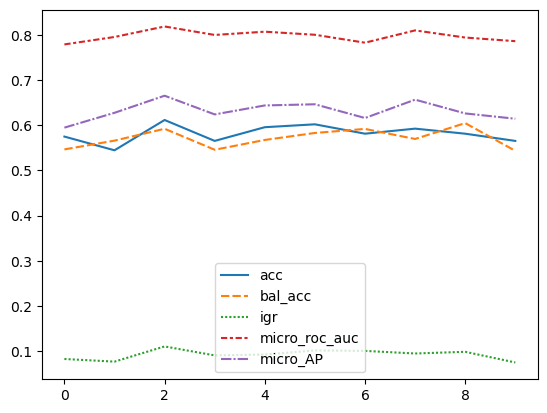

DG_Glut
zero: 5461, non-zero: 2849
0 : 213
100%|██████████| 20/20 [00:46<00:00,  2.31s/trial, best loss: -0.4191739883821487] 
IGR: 0.063; Balanced Accuracy: 0.553; Acuracy: 0.564; micro AP: 0.569; micro AUROC: 0.777


 94%|=================== | 12911/13674 [00:16<00:00]       

zero: 5461, non-zero: 2849
1 : 156
100%|██████████| 20/20 [00:40<00:00,  2.02s/trial, best loss: -0.4199940969737145]
IGR: 0.039; Balanced Accuracy: 0.478; Acuracy: 0.550; micro AP: 0.547; micro AUROC: 0.771


 97%|=================== | 13261/13674 [00:11<00:00]       

zero: 5461, non-zero: 2849
2 : 119
100%|██████████| 20/20 [00:34<00:00,  1.71s/trial, best loss: -0.4205763805658863] 
IGR: 0.071; Balanced Accuracy: 0.563; Acuracy: 0.590; micro AP: 0.598; micro AUROC: 0.795


 93%|=================== | 12681/13674 [00:11<00:00]       

zero: 5461, non-zero: 2849
3 : 93
100%|██████████| 20/20 [00:33<00:00,  1.66s/trial, best loss: -0.42339474567032237]
IGR: 0.043; Balanced Accuracy: 0.514; Acuracy: 0.532; micro AP: 0.553; micro AUROC: 0.771
zero: 5461, non-zero: 2849
4 : 76
100%|██████████| 20/20 [00:32<00:00,  1.64s/trial, best loss: -0.4284194417254753]
IGR: 0.050; Balanced Accuracy: 0.515; Acuracy: 0.569; micro AP: 0.558; micro AUROC: 0.776
zero: 5461, non-zero: 2849
5 : 59
100%|██████████| 20/20 [00:24<00:00,  1.20s/trial, best loss: -0.43121971978962603]
IGR: 0.071; Balanced Accuracy: 0.538; Acuracy: 0.603; micro AP: 0.601; micro AUROC: 0.803
zero: 5461, non-zero: 2849
6 : 49
100%|██████████| 20/20 [00:22<00:00,  1.13s/trial, best loss: -0.4272325292060726] 
IGR: 0.043; Balanced Accuracy: 0.502; Acuracy: 0.561; micro AP: 0.587; micro AUROC: 0.789
zero: 5461, non-zero: 2849
7 : 40
100%|██████████| 20/20 [00:24<00:00,  1.25s/trial, best loss: -0.4440710619904258] 
IGR: 0.048; Balanced Accuracy: 0.517; Acuracy: 0.55

 98%|===================| 13440/13674 [00:14<00:00]        

zero: 5461, non-zero: 2849
8 : 34
100%|██████████| 20/20 [00:19<00:00,  1.04trial/s, best loss: -0.43889494591644906]
IGR: 0.055; Balanced Accuracy: 0.524; Acuracy: 0.583; micro AP: 0.602; micro AUROC: 0.798


 98%|===================| 13463/13674 [00:14<00:00]        

zero: 5461, non-zero: 2849
9 : 28
100%|██████████| 20/20 [00:20<00:00,  1.04s/trial, best loss: -0.42647792254241323]
IGR: 0.069; Balanced Accuracy: 0.571; Acuracy: 0.567; micro AP: 0.580; micro AUROC: 0.788


 95%|=================== | 12949/13674 [00:11<00:00]       

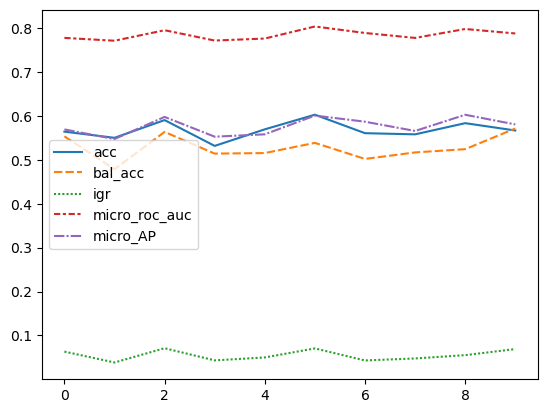

CA1-ProS_Glut
zero: 6930, non-zero: 1219
0 : 189
100%|██████████| 20/20 [00:39<00:00,  1.99s/trial, best loss: -0.5163125921264062]
IGR: 0.147; Balanced Accuracy: 0.592; Acuracy: 0.570; micro AP: 0.611; micro AUROC: 0.782
zero: 6930, non-zero: 1219
1 : 117
100%|██████████| 20/20 [00:21<00:00,  1.09s/trial, best loss: -0.5057459321192526]
IGR: 0.150; Balanced Accuracy: 0.594; Acuracy: 0.566; micro AP: 0.598; micro AUROC: 0.782
zero: 6930, non-zero: 1219
2 : 67
100%|██████████| 20/20 [00:15<00:00,  1.32trial/s, best loss: -0.5093692179397402]
IGR: 0.182; Balanced Accuracy: 0.631; Acuracy: 0.621; micro AP: 0.655; micro AUROC: 0.804
zero: 6930, non-zero: 1219
3 : 52
100%|██████████| 20/20 [00:12<00:00,  1.65trial/s, best loss: -0.5195056986807393]
IGR: 0.151; Balanced Accuracy: 0.604; Acuracy: 0.590; micro AP: 0.602; micro AUROC: 0.776
zero: 6930, non-zero: 1219
4 : 46
100%|██████████| 20/20 [00:12<00:00,  1.65trial/s, best loss: -0.5238328270818019]
IGR: 0.145; Balanced Accuracy: 0.603; A

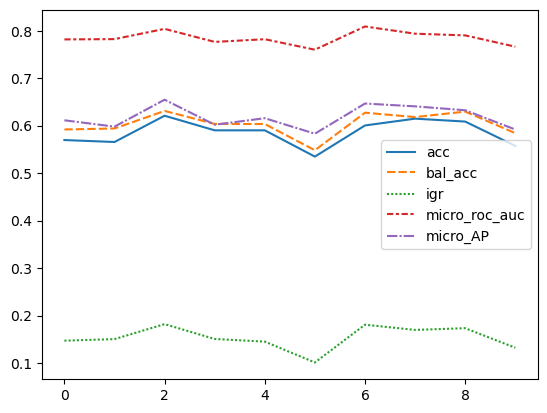

Oligo_NN
zero: 4009, non-zero: 1537
0 : 219
100%|██████████| 20/20 [00:33<00:00,  1.68s/trial, best loss: -0.5592252543781809]
IGR: 0.208; Balanced Accuracy: 0.652; Acuracy: 0.611; micro AP: 0.656; micro AUROC: 0.810
zero: 4009, non-zero: 1537
1 : 177
100%|██████████| 20/20 [00:29<00:00,  1.50s/trial, best loss: -0.5590980002952618]
IGR: 0.245; Balanced Accuracy: 0.680; Acuracy: 0.652; micro AP: 0.678; micro AUROC: 0.833
zero: 4009, non-zero: 1537
2 : 134
100%|██████████| 20/20 [00:22<00:00,  1.13s/trial, best loss: -0.5691010806588399]
IGR: 0.238; Balanced Accuracy: 0.679; Acuracy: 0.659; micro AP: 0.714; micro AUROC: 0.848
zero: 4009, non-zero: 1537
3 : 116
100%|██████████| 20/20 [00:23<00:00,  1.17s/trial, best loss: -0.5635363169284682]
IGR: 0.251; Balanced Accuracy: 0.696; Acuracy: 0.676; micro AP: 0.688; micro AUROC: 0.836
zero: 4009, non-zero: 1537
4 : 91
100%|██████████| 20/20 [00:29<00:00,  1.48s/trial, best loss: -0.5722613858910554]
IGR: 0.211; Balanced Accuracy: 0.651; Acur

100%|===================| 7369/7377 [00:12<00:00]        

zero: 4009, non-zero: 1537
7 : 49
100%|██████████| 20/20 [00:24<00:00,  1.24s/trial, best loss: -0.5692183710766475]
IGR: 0.259; Balanced Accuracy: 0.686; Acuracy: 0.662; micro AP: 0.706; micro AUROC: 0.841
zero: 4009, non-zero: 1537
8 : 40
100%|██████████| 20/20 [00:18<00:00,  1.07trial/s, best loss: -0.5727533081295884]
IGR: 0.222; Balanced Accuracy: 0.663; Acuracy: 0.639; micro AP: 0.702; micro AUROC: 0.840
zero: 4009, non-zero: 1537
9 : 31
100%|██████████| 20/20 [00:18<00:00,  1.07trial/s, best loss: -0.570698465410542] 
IGR: 0.245; Balanced Accuracy: 0.685; Acuracy: 0.652; micro AP: 0.676; micro AUROC: 0.829


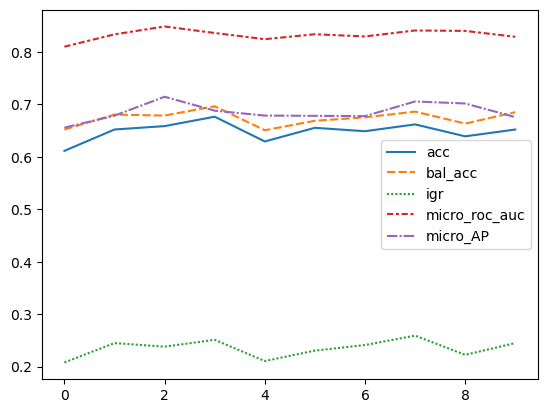

CA3_Glut
zero: 7816, non-zero: 861
0 : 179
100%|██████████| 20/20 [00:39<00:00,  1.98s/trial, best loss: -0.46374966985984634]
IGR: 0.099; Balanced Accuracy: 0.566; Acuracy: 0.562; micro AP: 0.595; micro AUROC: 0.789
zero: 7816, non-zero: 861
1 : 107
100%|██████████| 20/20 [00:23<00:00,  1.16s/trial, best loss: -0.46762317844351964]
IGR: 0.106; Balanced Accuracy: 0.557; Acuracy: 0.513; micro AP: 0.529; micro AUROC: 0.746
zero: 7816, non-zero: 861
2 : 77
100%|██████████| 20/20 [00:19<00:00,  1.02trial/s, best loss: -0.48571024299974686]
IGR: 0.126; Balanced Accuracy: 0.606; Acuracy: 0.600; micro AP: 0.603; micro AUROC: 0.793
zero: 7816, non-zero: 861
3 : 54
100%|██████████| 20/20 [00:17<00:00,  1.11trial/s, best loss: -0.4786288761251818]
IGR: 0.119; Balanced Accuracy: 0.586; Acuracy: 0.594; micro AP: 0.637; micro AUROC: 0.802
zero: 7816, non-zero: 861
4 : 45
100%|██████████| 20/20 [00:15<00:00,  1.27trial/s, best loss: -0.48635730305418]  
IGR: 0.168; Balanced Accuracy: 0.642; Acuracy:

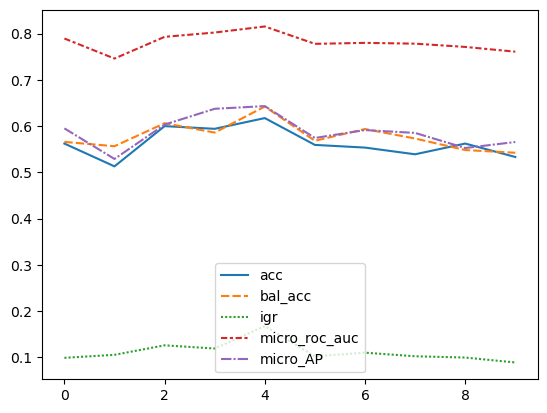

L6_CT_CTX_Glut
zero: 7885, non-zero: 1471
0 : 229
100%|██████████| 20/20 [00:34<00:00,  1.73s/trial, best loss: -0.49154306461701436]
IGR: 0.120; Balanced Accuracy: 0.608; Acuracy: 0.621; micro AP: 0.641; micro AUROC: 0.816
zero: 7885, non-zero: 1471
1 : 159
100%|██████████| 20/20 [00:28<00:00,  1.43s/trial, best loss: -0.4930551762339243] 
IGR: 0.141; Balanced Accuracy: 0.601; Acuracy: 0.655; micro AP: 0.676; micro AUROC: 0.835
zero: 7885, non-zero: 1471
2 : 129
100%|██████████| 20/20 [00:26<00:00,  1.32s/trial, best loss: -0.4780239476101442]
IGR: 0.133; Balanced Accuracy: 0.630; Acuracy: 0.623; micro AP: 0.656; micro AUROC: 0.827
zero: 7885, non-zero: 1471
3 : 93
100%|██████████| 20/20 [00:18<00:00,  1.08trial/s, best loss: -0.4874120576232056]
IGR: 0.126; Balanced Accuracy: 0.598; Acuracy: 0.625; micro AP: 0.657; micro AUROC: 0.824
zero: 7885, non-zero: 1471
4 : 84
100%|██████████| 20/20 [00:23<00:00,  1.16s/trial, best loss: -0.4927596242858261]
IGR: 0.116; Balanced Accuracy: 0.62

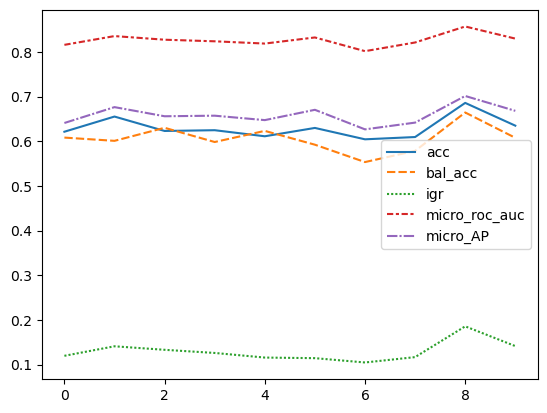

L6_IT_CTX_Glut
zero: 9063, non-zero: 190
0 : 205
100%|██████████| 20/20 [00:24<00:00,  1.22s/trial, best loss: -0.45845033283628955]
IGR: 0.176; Balanced Accuracy: 0.584; Acuracy: 0.684; micro AP: 0.636; micro AUROC: 0.808
zero: 9063, non-zero: 190
1 : 111
100%|██████████| 20/20 [00:16<00:00,  1.21trial/s, best loss: -0.5202803618413756]
IGR: 0.166; Balanced Accuracy: 0.584; Acuracy: 0.684; micro AP: 0.610; micro AUROC: 0.805
zero: 9063, non-zero: 190
2 : 78
100%|██████████| 20/20 [00:12<00:00,  1.56trial/s, best loss: -0.4595428817814421]
IGR: 0.132; Balanced Accuracy: 0.589; Acuracy: 0.618; micro AP: 0.699; micro AUROC: 0.835
zero: 9063, non-zero: 190
3 : 59
100%|██████████| 20/20 [00:10<00:00,  1.90trial/s, best loss: -0.511914531999055]
IGR: 0.147; Balanced Accuracy: 0.599; Acuracy: 0.632; micro AP: 0.693; micro AUROC: 0.825
zero: 9063, non-zero: 190
4 : 42
100%|██████████| 20/20 [00:08<00:00,  2.33trial/s, best loss: -0.5040450699502723]
IGR: 0.167; Balanced Accuracy: 0.589; Acura

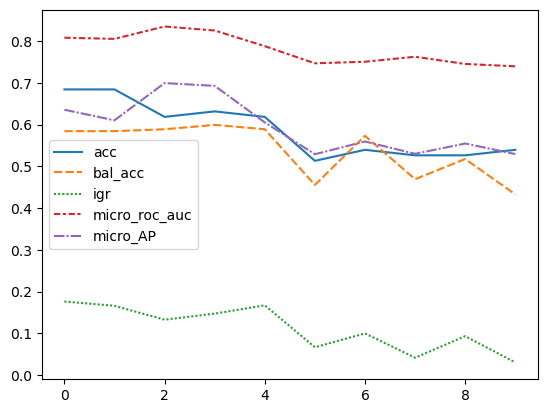

L5_ET_CTX_Glut
zero: 8692, non-zero: 491
0 : 195
100%|██████████| 20/20 [00:27<00:00,  1.37s/trial, best loss: -0.4488867355175834]
IGR: 0.119; Balanced Accuracy: 0.584; Acuracy: 0.569; micro AP: 0.664; micro AUROC: 0.812
zero: 8692, non-zero: 491
1 : 145
100%|██████████| 20/20 [00:22<00:00,  1.10s/trial, best loss: -0.4627936372045159] 
IGR: 0.092; Balanced Accuracy: 0.535; Acuracy: 0.599; micro AP: 0.622; micro AUROC: 0.799
zero: 8692, non-zero: 491
2 : 88
100%|██████████| 20/20 [00:15<00:00,  1.31trial/s, best loss: -0.45433170486569346]
IGR: 0.148; Balanced Accuracy: 0.610; Acuracy: 0.645; micro AP: 0.697; micro AUROC: 0.829
zero: 8692, non-zero: 491
3 : 58
100%|██████████| 20/20 [00:11<00:00,  1.69trial/s, best loss: -0.4707002915942071] 
IGR: 0.133; Balanced Accuracy: 0.624; Acuracy: 0.594; micro AP: 0.605; micro AUROC: 0.788
zero: 8692, non-zero: 491
4 : 51
100%|██████████| 20/20 [00:10<00:00,  1.91trial/s, best loss: -0.4818549846759678]
IGR: 0.153; Balanced Accuracy: 0.641; Ac

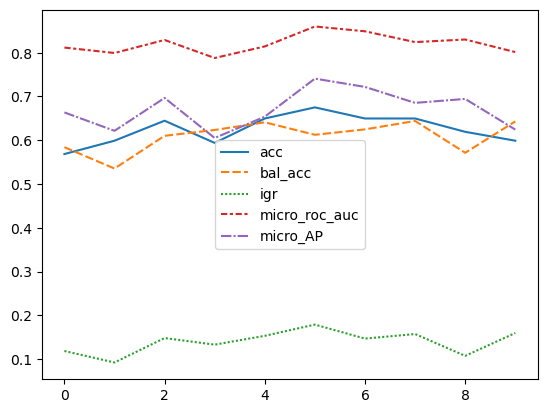

Astro-TE_NN
zero: 6436, non-zero: 193
0 : 251
100%|██████████| 20/20 [00:31<00:00,  1.55s/trial, best loss: -0.576776043704317]
IGR: 0.141; Balanced Accuracy: 0.582; Acuracy: 0.551; micro AP: 0.649; micro AUROC: 0.787
zero: 6436, non-zero: 193
1 : 140
100%|██████████| 20/20 [00:19<00:00,  1.05trial/s, best loss: -0.5713745832611263]
IGR: 0.395; Balanced Accuracy: 0.769; Acuracy: 0.718; micro AP: 0.745; micro AUROC: 0.850
zero: 6436, non-zero: 193
2 : 84
100%|██████████| 20/20 [00:18<00:00,  1.09trial/s, best loss: -0.5932297829699826]
IGR: 0.275; Balanced Accuracy: 0.680; Acuracy: 0.654; micro AP: 0.692; micro AUROC: 0.839
zero: 6436, non-zero: 193
3 : 53
100%|██████████| 20/20 [00:10<00:00,  1.90trial/s, best loss: -0.5602165455782641]
IGR: 0.287; Balanced Accuracy: 0.705; Acuracy: 0.667; micro AP: 0.672; micro AUROC: 0.832
zero: 6436, non-zero: 193
4 : 32
100%|██████████| 20/20 [00:07<00:00,  2.66trial/s, best loss: -0.5551285638049528]
IGR: 0.371; Balanced Accuracy: 0.745; Acuracy: 

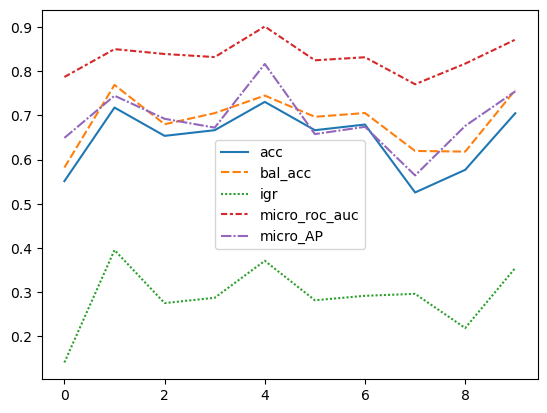

OPC_NN
zero: 6262, non-zero: 170
0 : 189
100%|██████████| 20/20 [00:23<00:00,  1.16s/trial, best loss: -0.5633759550924017]
IGR: 0.161; Balanced Accuracy: 0.562; Acuracy: 0.603; micro AP: 0.669; micro AUROC: 0.780
zero: 6262, non-zero: 170
1 : 110
100%|██████████| 20/20 [00:15<00:00,  1.26trial/s, best loss: -0.5485353995700736]
IGR: 0.446; Balanced Accuracy: 0.762; Acuracy: 0.794; micro AP: 0.739; micro AUROC: 0.882
zero: 6262, non-zero: 170
2 : 74
100%|██████████| 20/20 [00:12<00:00,  1.65trial/s, best loss: -0.5538793161955667]
IGR: 0.247; Balanced Accuracy: 0.564; Acuracy: 0.676; micro AP: 0.710; micro AUROC: 0.854
zero: 6262, non-zero: 170
3 : 49
100%|██████████| 20/20 [00:09<00:00,  2.19trial/s, best loss: -0.564732479787969] 
IGR: 0.346; Balanced Accuracy: 0.669; Acuracy: 0.735; micro AP: 0.774; micro AUROC: 0.866
zero: 6262, non-zero: 170
4 : 34
100%|██████████| 20/20 [00:07<00:00,  2.60trial/s, best loss: -0.5345999847808761] 
IGR: 0.397; Balanced Accuracy: 0.695; Acuracy: 0.7

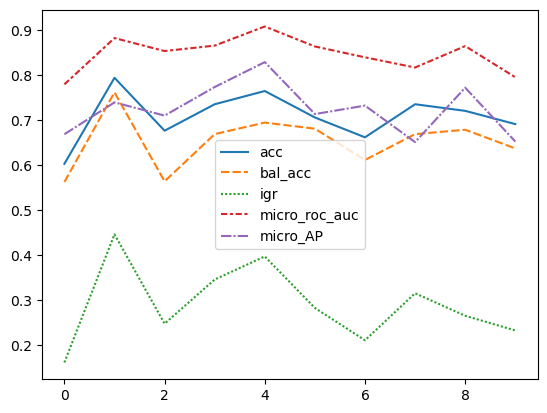

Pvalb_Gaba
zero: 7340, non-zero: 148
0 : 207
100%|██████████| 20/20 [00:22<00:00,  1.14s/trial, best loss: -0.5819660102776172]
IGR: 0.181; Balanced Accuracy: 0.629; Acuracy: 0.533; micro AP: 0.546; micro AUROC: 0.771
zero: 7340, non-zero: 148
1 : 200
100%|██████████| 20/20 [00:22<00:00,  1.14s/trial, best loss: -0.6337844200474989]
IGR: 0.148; Balanced Accuracy: 0.565; Acuracy: 0.617; micro AP: 0.591; micro AUROC: 0.796
zero: 7340, non-zero: 148
2 : 108
100%|██████████| 20/20 [00:15<00:00,  1.31trial/s, best loss: -0.5984442859319415]
IGR: 0.306; Balanced Accuracy: 0.737; Acuracy: 0.750; micro AP: 0.690; micro AUROC: 0.835
zero: 7340, non-zero: 148
3 : 98
100%|██████████| 20/20 [00:13<00:00,  1.46trial/s, best loss: -0.6160780629610001]
IGR: 0.172; Balanced Accuracy: 0.583; Acuracy: 0.550; micro AP: 0.530; micro AUROC: 0.767
zero: 7340, non-zero: 148
4 : 49
100%|██████████| 20/20 [00:08<00:00,  2.25trial/s, best loss: -0.599015345314185]
IGR: 0.257; Balanced Accuracy: 0.721; Acuracy: 

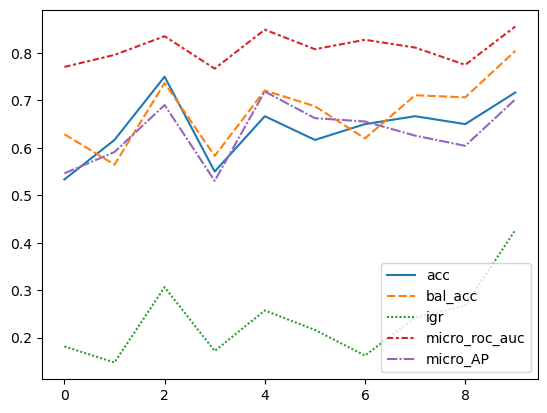

In [77]:
for _ct in cell_types: 
    print(_ct)
    metrics_dict = {'acc' : [],  'bal_acc' : [], 'igr' : [], 'micro_roc_auc' : [], 'micro_AP' : []}
    
    with PdfPages(f"../result_data/xgb_mods/metric_img/{_ct}.train.pdf") as pdf:
        
        for jj in range(0, 10):
            if jj == 0: 
                DATA_FEATURE_NAMES_SUB = DATA_FEATURE_NAMES.copy()
            
            X_balanced, y_balanced, FEATURE_TYPES = load_data_wrapper(_ct, DATA_FEATURE_NAMES_SUB, 
                                                                      y_val=p_y_val, _testing_type=p_testing_type, rna_type=p_rna_type, 
                                                                     data_filepath = p_data_filepath, na_cutoff=p_na_cutoff)
            
            y_balanced += 1 # for 0, 1, 2, labels
            X = aggregate_modalities(X_balanced, FEATURE_TYPES)
            X_train, X_test, y_train, y_test, kf = split_and_normalize(X, y_balanced, test_size=0.2, random_state=13)

            # if jj == 0: 
            #     y_train.to_csv(f"../result_data/xgb_mods/celltype_models/{_ct}.Y_train.csv")
            #     y_test.to_csv(f"../result_data/xgb_mods/celltype_models/{_ct}.Y_test.csv")
            #     X_balanced.to_csv(f"../result_data/xgb_mods/celltype_models/{_ct}.X_all.csv")
            #     X_train.to_csv(f"../result_data/xgb_mods/celltype_models/{_ct}.X_train.csv")
            #     X_test.to_csv(f"../result_data/xgb_mods/celltype_models/{_ct}.X_test.csv")
        
            # dtrain_reg = xgb.DMatrix(X_train, y_train)
            # dtest_reg = xgb.DMatrix(X_test, y_test)
            print(jj, ":", len(X_train.columns))
            
            # Training the actual model
            xgb_mod = train_model(X_train, y_train, X_train.columns, objective, space, num_evals=20)
        
            # Getting some evaluation metrics
            y_pred = xgb_mod.predict(X_test)
            y_score = xgb_mod.predict_proba(X_test)
            max_gain = information_gain(y_test, y_test)
            gain_ratio = information_gain(y_test, y_pred) / max_gain
            bal_acc = balanced_accuracy_score(y_test, y_pred)
            acc = accuracy_score(y_test, y_pred)
            micro_roc_auc_ovr = roc_auc_score(y_test, y_score, multi_class="ovr", average="micro")
            prec, rec, micro_AP = micro_PRC(y_test, y_score)
            
            metrics_dict['igr'].append(gain_ratio)
            metrics_dict['bal_acc'].append(bal_acc)
            metrics_dict['acc'].append(acc)
            metrics_dict['micro_roc_auc'].append(micro_roc_auc_ovr)
            metrics_dict['micro_AP'].append(micro_AP)
    
            print("IGR: %.3f; Balanced Accuracy: %.3f; Acuracy: %.3f; micro AP: %.3f; micro AUROC: %.3f" % (gain_ratio, bal_acc, acc, micro_AP, micro_roc_auc_ovr))
    
            ccf_metrics(X_train, X_test, y_train, y_test)
            pdf.savefig(dpi=300, bbox_inches='tight')
            plt.close()
        
            with open(f'../result_data/xgb_mods/celltype_models/{_ct}.train.{jj}.pkl', 'wb') as f: 
                pickle.dump(xgb_mod, f)
        
            if jj == 0: 
                df_feats = pd.DataFrame(X_train.columns).set_index(0)
                df_feats.index.name = "features"
                df_feats[f'epoch_{jj}'] = True
            else: 
                df_feats[f'epoch_{jj}'] = False
                df_feats.loc[X_train.columns, f'epoch_{jj}'] = True
            df_feats.to_csv(f"../result_data/xgb_mods/celltype_features/{_ct}.train.csv")
            
            
            # Getting the shap values
            explainer = shap.TreeExplainer(xgb_mod, X_train) # , feature_perturbation='interventional', model_output="predict_proba")
            shap_values = explainer(X_train, check_additivity=False)
            # Getting the next set of features
            ranked_order = rank_ordering_from_shap(shap_values, X_train)
            # downsampling 50% at a time
            ds = 0.5*len(X_train.columns)
            DATA_FEATURE_NAMES_SUB = generate_ct_features(ranked_order, num_downsample=ds)
    
    df_metrics = pd.DataFrame.from_dict(metrics_dict)
    df_metrics.to_csv(f"../result_data/xgb_mods/metric_img/{_ct}.train.metrics.csv")
    sns.lineplot(df_metrics)
    plt.show()

### Model Search 2
Searching for a model by not having a test set and just doing a 5 fold CV search for both hyperparameters (first), and then feature importance. Iterating this for ten epochs (also having a variable rate of feature importance selection), since all of the data is used both for training and testing (via the CV search), I use the accumulation of feature importance scores from the validation set of the 5 folds. 

#### function redefinitions

In [ ]:
def split(X, y_balanced, random_state:int=13): 
    # Split by numerical or non non-numerical columns
    X_str = X[X.dtypes[X.dtypes=='object'].index]
    X_str = X_str.astype("category")
    X_numerical = X[X.dtypes[X.dtypes!='object'].index]
    
    # X = X_str.merge(X_numerical, left_on='gene_name', right_on='gene_name')
    X = X_numerical
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    return X, y_balanced, kf

In [ ]:
# Defining the Search Space
space = {'max_depth': hp.quniform("max_depth", 3, 18, 1), 
        'gamma' : hp.uniform('gamma', 0.5, 5), 
        'reg_alpha' : hp.quniform('reg_alpha', 1, 40, 1), 
        'reg_lambda': hp.uniform('reg_lambda', 0, 1), 
        'n_estimators': hp.quniform('n_estimators', 50, 200, 5),
        'seed' : 13
        }

def objective(space): 

    # Doing the kfold split for the hyperparameter tuning part
    accuracies = []
    for i, (train_idx, test_idx) in enumerate(kf.split(X, y_balanced)): 
        X_train = X.iloc[train_idx]
        X_test = X.iloc[test_idx]
        y_train = y_balanced.iloc[train_idx]
        y_test = y_balanced.iloc[test_idx]
        # sample_weights = compute_sample_weight(class_weight="balanced", y=y_tr)
        sample_weights, sw_te = AK_sample_weights(y_train, y_test)
        
        xgb_mod = xgb.XGBClassifier( enable_categorical=True, 
            n_estimators = int(space['n_estimators']), max_depth = int(space['max_depth']),                         
            gamma = space['gamma'], reg_alpha=space['reg_alpha'], reg_lambda=space['reg_lambda'], 
            seed=space['seed'] )
    
        
        # evaluation = [(X_train, y_train, X_test, y_test)]
        xgb_mod = xgb_mod.fit(X_train, y_train, sample_weight=sample_weights)
        
        pred = xgb_mod.predict(X_test)
        
        max_gain = information_gain(y_test, y_test)
        gain_ratio = information_gain(y_test, pred) / max_gain
        bal_accuracy = balanced_accuracy_score(y_test, pred, sample_weight=sw_te)    
        accuracies.append(gain_ratio*0.2 + 0.8*bal_accuracy)  
    
    res_acc = np.mean(accuracies)
    return {'loss' : -res_acc, 'status' : STATUS_OK}

#### run

In [15]:
# PARAMETERS
p_y_val = "DEG"
p_testing_type = "balanced_2"
p_rna_type = "luisa"
p_data_filepath = f"../data/v3"
p_na_cutoff=0.5
random_state = 13
SAMPLE_FEATURES = False
num_evals=20

L23_IT_CTX_Glut
zero: 7789, non-zero: 1564
0 : 205
100%|██████████| 20/20 [00:55<00:00,  2.79s/trial, best loss: -0.5254589648029319]
zero: 7789, non-zero: 1564
1 : 142
100%|██████████| 20/20 [00:47<00:00,  2.39s/trial, best loss: -0.48424206644016604]
zero: 7789, non-zero: 1564
2 : 125
100%|██████████| 20/20 [00:37<00:00,  1.85s/trial, best loss: -0.493363518077225] 
zero: 7789, non-zero: 1564
3 : 109
100%|██████████| 20/20 [00:35<00:00,  1.78s/trial, best loss: -0.49114523948039623]
zero: 7789, non-zero: 1564
4 : 92
100%|██████████| 20/20 [00:34<00:00,  1.75s/trial, best loss: -0.4891402733602611] 
zero: 7789, non-zero: 1564
5 : 81
100%|██████████| 20/20 [00:32<00:00,  1.64s/trial, best loss: -0.4831818225597779]
zero: 7789, non-zero: 1564
6 : 74
100%|██████████| 20/20 [00:39<00:00,  1.97s/trial, best loss: -0.5033618162825404]
zero: 7789, non-zero: 1564
7 : 69
100%|██████████| 20/20 [00:37<00:00,  1.89s/trial, best loss: -0.4949548065837736]
zero: 7789, non-zero: 1564
8 : 66
100%|██

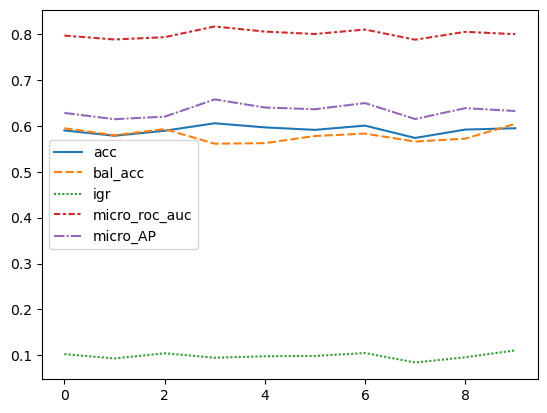

DG_Glut
zero: 5461, non-zero: 2849
0 : 213
100%|██████████| 20/20 [01:04<00:00,  3.20s/trial, best loss: -0.4419230612245486]
zero: 5461, non-zero: 2849
1 : 148
100%|██████████| 20/20 [01:17<00:00,  3.86s/trial, best loss: -0.4326356103263616] 
zero: 5461, non-zero: 2849
2 : 128
100%|██████████| 20/20 [00:46<00:00,  2.33s/trial, best loss: -0.43446646104854514]
zero: 5461, non-zero: 2849
3 : 109
100%|██████████| 20/20 [00:41<00:00,  2.08s/trial, best loss: -0.425422514415913]
zero: 5461, non-zero: 2849
4 : 96
100%|██████████| 20/20 [00:41<00:00,  2.08s/trial, best loss: -0.4324657324043983] 
zero: 5461, non-zero: 2849
5 : 78
100%|██████████| 20/20 [00:37<00:00,  1.89s/trial, best loss: -0.431530211424106]  
zero: 5461, non-zero: 2849
6 : 66
100%|██████████| 20/20 [00:42<00:00,  2.11s/trial, best loss: -0.42895196560345294]
zero: 5461, non-zero: 2849
7 : 53
100%|██████████| 20/20 [00:45<00:00,  2.29s/trial, best loss: -0.43174281159082695]
zero: 5461, non-zero: 2849
8 : 45
100%|████████

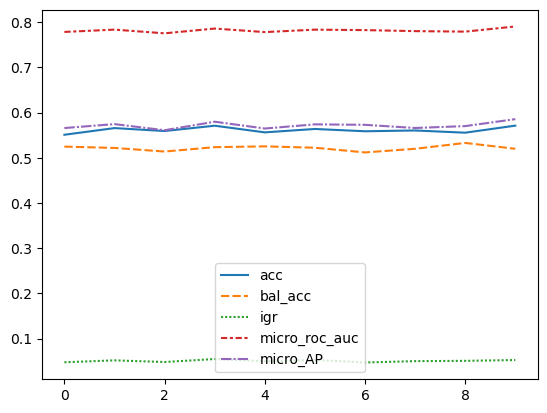

CA1-ProS_Glut
zero: 6930, non-zero: 1219
0 : 189
100%|██████████| 20/20 [00:52<00:00,  2.62s/trial, best loss: -0.4708124255790347]
zero: 6930, non-zero: 1219
1 : 157
100%|██████████| 20/20 [00:52<00:00,  2.63s/trial, best loss: -0.5182092843725368]
zero: 6930, non-zero: 1219
2 : 131
100%|██████████| 20/20 [00:52<00:00,  2.62s/trial, best loss: -0.5203569044036894]
zero: 6930, non-zero: 1219
3 : 107
100%|██████████| 20/20 [00:35<00:00,  1.76s/trial, best loss: -0.514084295143609]
zero: 6930, non-zero: 1219
4 : 89
100%|██████████| 20/20 [00:30<00:00,  1.52s/trial, best loss: -0.5078085149476105]
zero: 6930, non-zero: 1219
5 : 77
100%|██████████| 20/20 [00:27<00:00,  1.39s/trial, best loss: -0.5234751324501609]
zero: 6930, non-zero: 1219
6 : 66
100%|██████████| 20/20 [00:24<00:00,  1.23s/trial, best loss: -0.5149668287531268]
zero: 6930, non-zero: 1219
7 : 51
100%|██████████| 20/20 [00:34<00:00,  1.72s/trial, best loss: -0.5164963046943566]
zero: 6930, non-zero: 1219
8 : 33
100%|████████

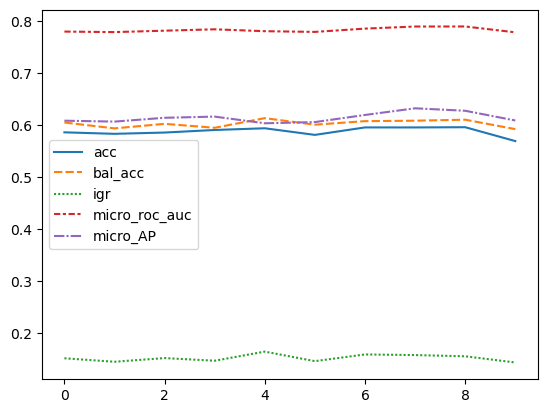

Oligo_NN
zero: 4009, non-zero: 1537
0 : 219
100%|██████████| 20/20 [00:55<00:00,  2.79s/trial, best loss: -0.571953638225372]
zero: 4009, non-zero: 1537
1 : 195
100%|██████████| 20/20 [00:50<00:00,  2.51s/trial, best loss: -0.5537761855672413]
zero: 4009, non-zero: 1537
2 : 162
100%|██████████| 20/20 [00:43<00:00,  2.19s/trial, best loss: -0.5723336319174037]
zero: 4009, non-zero: 1537
3 : 140
100%|██████████| 20/20 [00:45<00:00,  2.30s/trial, best loss: -0.5675878839958046]
zero: 4009, non-zero: 1537
4 : 116
100%|██████████| 20/20 [00:37<00:00,  1.86s/trial, best loss: -0.5755512658941664]
zero: 4009, non-zero: 1537
5 : 95
100%|██████████| 20/20 [00:32<00:00,  1.62s/trial, best loss: -0.5762390029172065]
zero: 4009, non-zero: 1537
6 : 77
100%|██████████| 20/20 [00:29<00:00,  1.49s/trial, best loss: -0.5709063256752738]
zero: 4009, non-zero: 1537
7 : 64
100%|██████████| 20/20 [00:27<00:00,  1.37s/trial, best loss: -0.5678847881054356]
zero: 4009, non-zero: 1537
8 : 54
100%|██████████| 

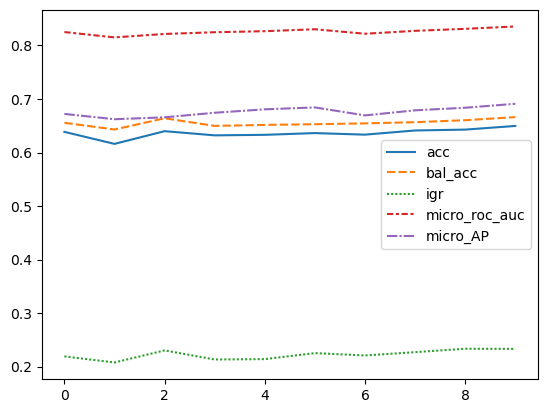

CA3_Glut
zero: 7816, non-zero: 861
0 : 179
100%|██████████| 20/20 [00:43<00:00,  2.17s/trial, best loss: -0.49566225618627724]
zero: 7816, non-zero: 861
1 : 149
100%|██████████| 20/20 [00:44<00:00,  2.21s/trial, best loss: -0.48727577449964354]
zero: 7816, non-zero: 861
2 : 114
100%|██████████| 20/20 [00:32<00:00,  1.63s/trial, best loss: -0.49576721470242724]
zero: 7816, non-zero: 861
3 : 99
100%|██████████| 20/20 [00:30<00:00,  1.52s/trial, best loss: -0.4803039567520949]
zero: 7816, non-zero: 861
4 : 80
100%|██████████| 20/20 [00:31<00:00,  1.55s/trial, best loss: -0.4954818169864666]
zero: 7816, non-zero: 861
5 : 68
100%|██████████| 20/20 [00:38<00:00,  1.92s/trial, best loss: -0.490016024312468]
zero: 7816, non-zero: 861
6 : 57
100%|██████████| 20/20 [00:20<00:00,  1.03s/trial, best loss: -0.4942476057923981]
zero: 7816, non-zero: 861
7 : 42
100%|██████████| 20/20 [00:21<00:00,  1.06s/trial, best loss: -0.48329166538937746]
zero: 7816, non-zero: 861
8 : 32
100%|██████████| 20/20 [

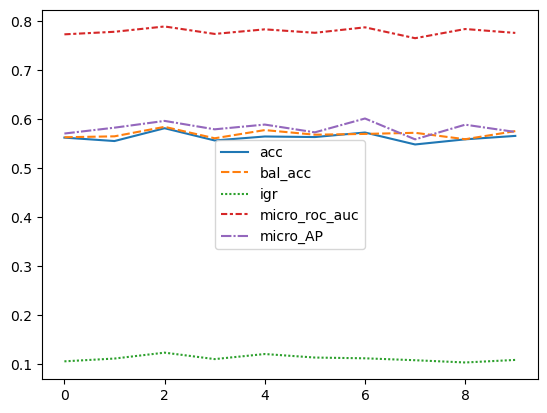

L6_CT_CTX_Glut
zero: 7885, non-zero: 1471
0 : 229
100%|██████████| 20/20 [00:58<00:00,  2.92s/trial, best loss: -0.49120616313311716]
zero: 7885, non-zero: 1471
1 : 161
100%|██████████| 20/20 [00:49<00:00,  2.45s/trial, best loss: -0.49480689851114884]
zero: 7885, non-zero: 1471
2 : 143
100%|██████████| 20/20 [00:49<00:00,  2.47s/trial, best loss: -0.4913479936863321]
zero: 7885, non-zero: 1471
3 : 130
100%|██████████| 20/20 [00:43<00:00,  2.18s/trial, best loss: -0.4903690152798326]
zero: 7885, non-zero: 1471
4 : 110
100%|██████████| 20/20 [00:49<00:00,  2.49s/trial, best loss: -0.495022887285746] 
zero: 7885, non-zero: 1471
5 : 94
100%|██████████| 20/20 [00:34<00:00,  1.75s/trial, best loss: -0.49051890975692247]
zero: 7885, non-zero: 1471
6 : 77
100%|██████████| 20/20 [00:28<00:00,  1.44s/trial, best loss: -0.49064622279630593]
zero: 7885, non-zero: 1471
7 : 63
100%|██████████| 20/20 [00:33<00:00,  1.70s/trial, best loss: -0.5017275228858719]
zero: 7885, non-zero: 1471
8 : 58
100%|█

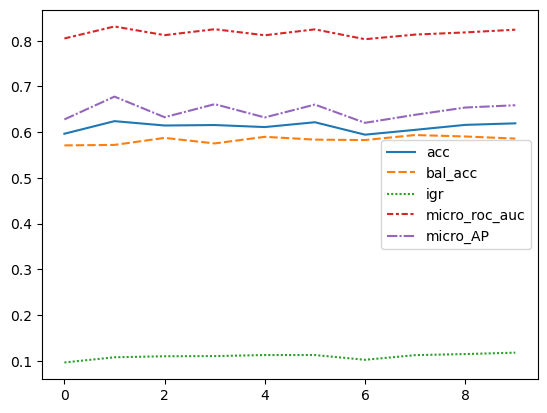

L6_IT_CTX_Glut
zero: 9063, non-zero: 190
0 : 205
100%|██████████| 20/20 [00:55<00:00,  2.76s/trial, best loss: -0.48954362066442486]
zero: 9063, non-zero: 190
1 : 84
100%|██████████| 20/20 [00:21<00:00,  1.06s/trial, best loss: -0.5012859186335856] 
zero: 9063, non-zero: 190
2 : 70
100%|██████████| 20/20 [00:24<00:00,  1.23s/trial, best loss: -0.47547773000360954]
zero: 9063, non-zero: 190
3 : 62
100%|██████████| 20/20 [00:29<00:00,  1.47s/trial, best loss: -0.465157642402259] 
zero: 9063, non-zero: 190
4 : 54
100%|██████████| 20/20 [00:27<00:00,  1.39s/trial, best loss: -0.4907181364282036]
zero: 9063, non-zero: 190
5 : 43
100%|██████████| 20/20 [00:23<00:00,  1.15s/trial, best loss: -0.5337740586227195]
zero: 9063, non-zero: 190
6 : 34
100%|██████████| 20/20 [00:15<00:00,  1.31trial/s, best loss: -0.49919131545955586]
zero: 9063, non-zero: 190
7 : 28
100%|██████████| 20/20 [00:15<00:00,  1.27trial/s, best loss: -0.48910479203547197]
zero: 9063, non-zero: 190
8 : 24
100%|██████████| 2

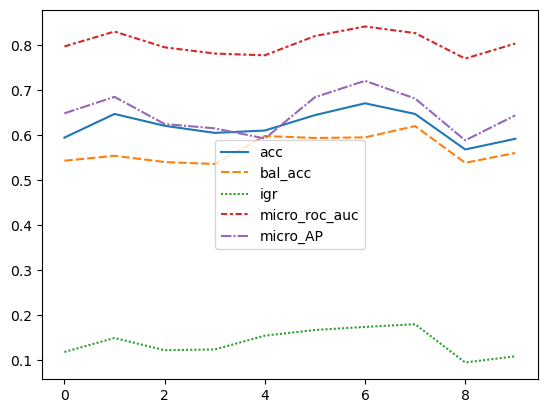

L5_ET_CTX_Glut
zero: 8692, non-zero: 491
0 : 195
100%|██████████| 20/20 [00:46<00:00,  2.30s/trial, best loss: -0.48698557424296646]
zero: 8692, non-zero: 491
1 : 92
100%|██████████| 20/20 [00:24<00:00,  1.23s/trial, best loss: -0.49601133077613363]
zero: 8692, non-zero: 491
2 : 74
100%|██████████| 20/20 [00:23<00:00,  1.18s/trial, best loss: -0.514258862373246] 
zero: 8692, non-zero: 491
3 : 56
100%|██████████| 20/20 [00:22<00:00,  1.14s/trial, best loss: -0.48271525410310295]
zero: 8692, non-zero: 491
4 : 45
100%|██████████| 20/20 [00:26<00:00,  1.32s/trial, best loss: -0.49007186995159396]
zero: 8692, non-zero: 491
5 : 39
100%|██████████| 20/20 [00:18<00:00,  1.06trial/s, best loss: -0.5145061561099389]
zero: 8692, non-zero: 491
6 : 34
100%|██████████| 20/20 [00:26<00:00,  1.33s/trial, best loss: -0.4753609571897274]
zero: 8692, non-zero: 491
7 : 32
100%|██████████| 20/20 [00:18<00:00,  1.06trial/s, best loss: -0.509238264767965] 
zero: 8692, non-zero: 491
8 : 27
100%|██████████| 20

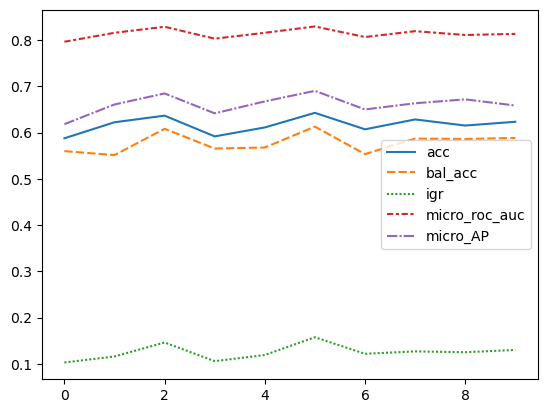

Astro-TE_NN
zero: 6436, non-zero: 193
0 : 251
100%|██████████| 20/20 [00:41<00:00,  2.08s/trial, best loss: -0.6048985396338655]
zero: 6436, non-zero: 193
1 : 149
100%|██████████| 20/20 [00:34<00:00,  1.71s/trial, best loss: -0.5861724877455469]
zero: 6436, non-zero: 193
2 : 126
100%|██████████| 20/20 [00:29<00:00,  1.49s/trial, best loss: -0.6219194064352345]
zero: 6436, non-zero: 193
3 : 115
100%|██████████| 20/20 [00:26<00:00,  1.34s/trial, best loss: -0.5806907135563352]
zero: 6436, non-zero: 193
4 : 75
100%|██████████| 20/20 [00:22<00:00,  1.12s/trial, best loss: -0.5891711278373564]
zero: 6436, non-zero: 193
5 : 68
100%|██████████| 20/20 [00:27<00:00,  1.36s/trial, best loss: -0.5590736335582751]
zero: 6436, non-zero: 193
6 : 63
100%|██████████| 20/20 [00:28<00:00,  1.43s/trial, best loss: -0.6092563551028313]
zero: 6436, non-zero: 193
7 : 53
100%|██████████| 20/20 [00:17<00:00,  1.11trial/s, best loss: -0.5871253606756568]
zero: 6436, non-zero: 193
8 : 47
100%|██████████| 20/20 

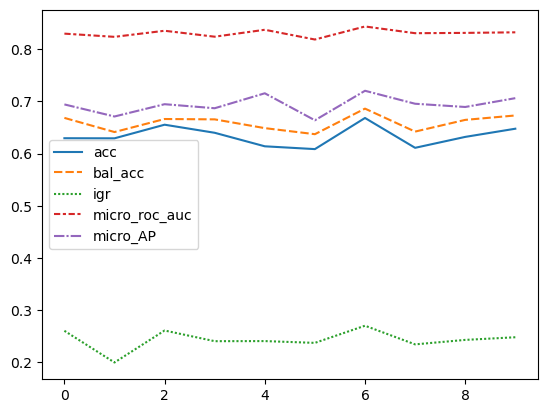

OPC_NN
zero: 6262, non-zero: 170
0 : 189
100%|██████████| 20/20 [00:36<00:00,  1.81s/trial, best loss: -0.5578088090195064]
zero: 6262, non-zero: 170
1 : 96
100%|██████████| 20/20 [00:27<00:00,  1.40s/trial, best loss: -0.5769000113755656]
zero: 6262, non-zero: 170
2 : 75
100%|██████████| 20/20 [00:25<00:00,  1.30s/trial, best loss: -0.5653413744355399]
zero: 6262, non-zero: 170
3 : 42
100%|██████████| 20/20 [00:17<00:00,  1.15trial/s, best loss: -0.5326454494455926]
zero: 6262, non-zero: 170
4 : 32
100%|██████████| 20/20 [00:15<00:00,  1.27trial/s, best loss: -0.5531143384849129]
zero: 6262, non-zero: 170
5 : 20
100%|██████████| 20/20 [00:19<00:00,  1.05trial/s, best loss: -0.5554496268230642]
zero: 6262, non-zero: 170
6 : 16
100%|██████████| 20/20 [00:17<00:00,  1.13trial/s, best loss: -0.5469495008556509]
zero: 6262, non-zero: 170
7 : 12
100%|██████████| 20/20 [00:19<00:00,  1.02trial/s, best loss: -0.5590146112628324]
zero: 6262, non-zero: 170
8 : 10
100%|██████████| 20/20 [00:16<0

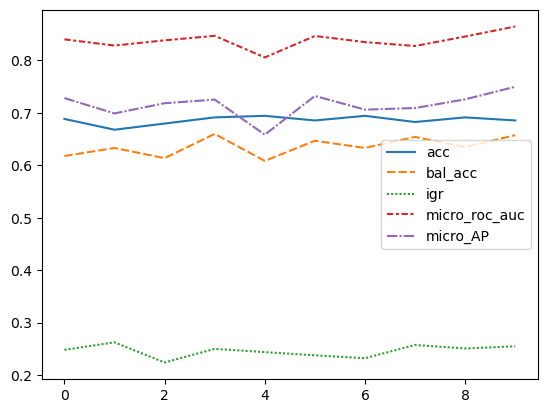

In [27]:
for _ct in cell_types: 
    print(_ct)
    metrics_dict = {'acc' : [],  'bal_acc' : [], 'igr' : [], 'micro_roc_auc' : [], 'micro_AP' : []}
    
    with PdfPages(f"../result_data/xgb_mods/metric_img/{_ct}.cv.pdf") as pdf:
        
        lr = 0.25
        for jj in range(0, 10):
            if jj == 0: 
                DATA_FEATURE_NAMES_SUB = DATA_FEATURE_NAMES.copy()
            
            X_balanced, y_balanced, FEATURE_TYPES = load_data_wrapper(_ct, DATA_FEATURE_NAMES_SUB, 
                                                                      y_val=p_y_val, _testing_type=p_testing_type, rna_type=p_rna_type, 
                                                                     data_filepath = p_data_filepath, na_cutoff=p_na_cutoff)
            
            y_balanced += 1 # for 0, 1, 2, labels
            X = aggregate_modalities(X_balanced, FEATURE_TYPES)
            X, y_balanced, kf = split(X, y_balanced, random_state=13)
            print(jj, ":", len(X.columns))

            
            # Performing the hyperparameter search
            trials = Trials()
            best_hyperparams = fmin(fn = objective, space = space, 
                                    algo = tpe.suggest, max_evals = num_evals, trials = trials)


            metrics_inner = {'acc' : [],  'bal_acc' : [], 'igr' : [], 'micro_roc_auc' : [], 'micro_AP' : []}
            pred_list = []
            true_list = []
            feature_set = set()

            kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=25)
            for i, (train_idx, test_idx) in enumerate(kf.split(X, y_balanced)): 
                X_train = X.iloc[train_idx]
                X_test = X.iloc[test_idx]
                y_train = y_balanced.iloc[train_idx]
                y_test = y_balanced.iloc[test_idx]
                # sample_weights = compute_sample_weight(class_weight="balanced", y=y_tr)
                sample_weights, sw_te = AK_sample_weights(y_train, y_test)
                
                # Training a model based on the best hyperparameters 
                xgb_mod = xgb.XGBClassifier(enable_categorical=False, max_depth=int(best_hyperparams['max_depth']), gamma=best_hyperparams['gamma'], 
                                            n_estimators = int(best_hyperparams['n_estimators']), reg_alpha = int(best_hyperparams['reg_alpha']), 
                                            reg_lambda = best_hyperparams['reg_lambda'], seed = 13)
                xgb_mod = xgb_mod.fit(X_train, y_train, sample_weight=sample_weights)
    
                # Getting some evaluation metrics
                y_pred = xgb_mod.predict(X_test)
                y_score = xgb_mod.predict_proba(X_test)
                max_gain = information_gain(y_test, y_test)
                gain_ratio = information_gain(y_test, y_pred) / max_gain
                bal_acc = balanced_accuracy_score(y_test, y_pred)
                acc = accuracy_score(y_test, y_pred)
                micro_roc_auc_ovr = roc_auc_score(y_test, y_score, multi_class="ovr", average="micro")
                prec, rec, micro_AP = micro_PRC(y_test, y_score)
            
                metrics_inner['igr'].append(gain_ratio)
                metrics_inner['bal_acc'].append(bal_acc)
                metrics_inner['acc'].append(acc)
                metrics_inner['micro_roc_auc'].append(micro_roc_auc_ovr)
                metrics_inner['micro_AP'].append(micro_AP)
                pred_list.extend(y_pred)
                true_list.extend(y_test)

                # Getting the shap values
                explainer = shap.TreeExplainer(xgb_mod, X_test) # , feature_perturbation='interventional', model_output="predict_proba")
                shap_values = explainer(X_test, check_additivity=False)
                
                # Getting the next set of features
                ranked_order = rank_ordering_from_shap(shap_values, X_test)
                # downsampling 50% at a time
                ds = lr*len(X_test.columns)
                features = generate_ct_features_p1(ranked_order, num_downsample=ds)
                for f in features: 
                    feature_set.add(f)
 
            metrics_dict['igr'].append(np.mean(metrics_inner['igr']))
            metrics_dict['bal_acc'].append(np.mean(metrics_inner['bal_acc']))
            metrics_dict['acc'].append(np.mean(metrics_inner['acc']))
            metrics_dict['micro_roc_auc'].append(np.mean(metrics_inner['micro_roc_auc']))
            metrics_dict['micro_AP'].append(np.mean(metrics_inner['micro_AP']))                
    
            # print("IGR: %.3f; Balanced Accuracy: %.3f; Acuracy: %.3f; micro AP: %.3f; micro AUROC: %.3f" % (gain_ratio, bal_acc, acc, micro_AP, micro_roc_auc_ovr))
    
            ccf_test = confusion_matrix(true_list, pred_list, normalize='true')
            fig, ax = plt.subplots(1, 1, figsize=(4, 5), constrained_layout=True)
            sns.heatmap(ccf_test, vmin=0, vmax=1, xticklabels = ['-1', '0', '1'], yticklabels = ['-1', '0', '1'], 
                        square=True, cmap='coolwarm', annot=True, cbar = False, ax=ax)
            ax.set_xlabel("Prediction")
            ax.set_ylabel("Label")
            ax.set_title("Test")
            pdf.savefig(dpi=300, bbox_inches='tight')
            plt.close()
        
            with open(f'../result_data/xgb_mods/celltype_models/{_ct}.cv.{jj}.pkl', 'wb') as f: 
                pickle.dump(xgb_mod, f)
        
            if jj == 0: 
                df_feats = pd.DataFrame(X_train.columns).set_index(0)
                df_feats.index.name = "features"
                df_feats[f'epoch_{jj}'] = True
            else: 
                df_feats[f'epoch_{jj}'] = False
                df_feats.loc[X_train.columns, f'epoch_{jj}'] = True
            df_feats.to_csv(f"../result_data/xgb_mods/celltype_features/{_ct}.cv.csv")
            
            DATA_FEATURE_NAMES_SUB = combine_ct_features(feature_set)
    
    df_metrics = pd.DataFrame.from_dict(metrics_dict)
    df_metrics.to_csv(f"../result_data/xgb_mods/metric_img/{_ct}.cv.metrics.csv")
    sns.lineplot(df_metrics)
    plt.show()
    lr += 0.05

### Pick Good Model
Using the results form the runs above (the saved quality metrics and feature sets), pick a model per cell type that is "best" and generate for it its predictions as well as its Shapley importance values and store them for use in the analysis. 

In [19]:
# PARAMETERS
p_y_val = "DEG"
p_testing_type = "balanced_2"
p_rna_type = "luisa"
p_data_filepath = f"../data/v3"
p_na_cutoff=0.5
random_state = 13
SAMPLE_FEATURES = False

In [21]:
def get_shap_dataframes(shap_values, X_df:pd.DataFrame, classes:list = ['down', 'non', 'up']): 
    """
    Return rank ordering as well as mean of the absolute values of each of the features
    """
    df_list = []
    for i, c in enumerate(classes):
        df_temp = pd.DataFrame(shap_values[:, :, i].values, 
                               columns=X_df.columns, 
                               index=X_df.index)
        df_list.append(df_temp.copy())

    return df_list

L23_IT_CTX_Glut
zero: 7789, non-zero: 1564
6 , num cols:  74
0.5782747603833865 0.5817269126929195
0.5734824281150159 0.5863997804373834
0.5463258785942492 0.6071545212022313
0.5968 0.6298009459374804
0.5456 0.5786935286935287


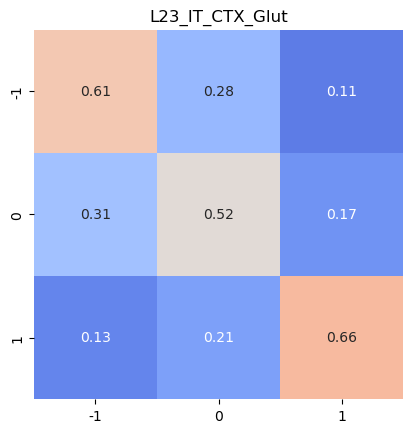

DG_Glut
zero: 5461, non-zero: 2849
3 , num cols:  109
0.5605263157894737 0.5997911445279867
0.5570175438596491 0.5398913951545531
0.5289473684210526 0.4806599832915623
0.5618964003511853 0.5034063501503288
0.5443371378402108 0.5152490188564557


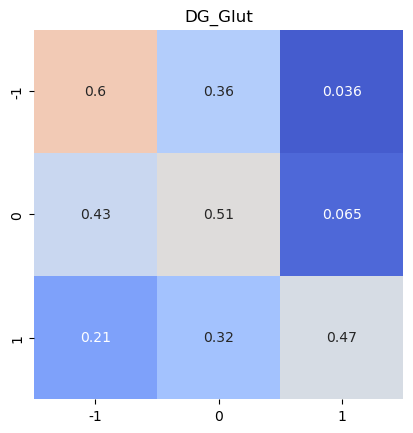

CA1-ProS_Glut
zero: 6930, non-zero: 1219
8 , num cols:  33
0.6004098360655737 0.6332658993140333
0.5594262295081968 0.6020310762922157
0.5450819672131147 0.5633267687963861


In [ ]:
for _ct in cell_types: 
    print(_ct)
            
    X_balanced, y_balanced, FEATURE_TYPES = load_data_wrapper(_ct, DATA_FEATURE_NAMES, 
                                                              y_val=p_y_val, _testing_type=p_testing_type, rna_type=p_rna_type, 
                                                             data_filepath = p_data_filepath, na_cutoff=p_na_cutoff)

    y_balanced += 1 # for 0, 1, 2, labels
    X = aggregate_modalities(X_balanced, FEATURE_TYPES)

    df_features = pd.read_csv(f"../result_data/xgb_mods/celltype_features/{_ct}.cv.csv", index_col=0)
    df_metrics = pd.read_csv(f"../result_data/xgb_mods/metric_img/{_ct}.cv.metrics.csv", index_col=0)
    
    best_mod = df_metrics.rank(ascending=True).sum(axis=1).argmax()
    # best_mod = df_metrics.rank(ascending=True)['bal_acc'].argmax()
    
    with open(f"../result_data/xgb_mods/celltype_models/{_ct}.cv.{best_mod}.pkl", 'rb') as f: 
        xgb_mod_loaded = pickle.load(f)
    params = xgb_mod_loaded.get_xgb_params()
    # Training a model based on the best hyperparameters 
    xgb_mod = xgb.XGBClassifier(enable_categorical=False, max_depth=int(params['max_depth']), gamma=params['gamma'], 
                                n_estimators = int(xgb_mod_loaded.n_estimators), reg_alpha = int(params['reg_alpha']), 
                                reg_lambda = params['reg_lambda'], seed = 13)

    X = X[xgb_mod_loaded.get_booster().feature_names].copy()
    print(best_mod, ", num cols: ", X.shape[1])

    Y_output = pd.DataFrame(y_balanced.copy())
    Y_output['pred'] = -1
    Y_output['score_0'] = -1.1
    Y_output['score_1'] = -1.1
    Y_output['score_2'] = -1.1

    df_down_list = []; df_non_list = []; df_up_list = []
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    for i, (train_idx, test_idx) in enumerate(kf.split(X, y_balanced)): 
        X_train = X.iloc[train_idx]
        X_test = X.iloc[test_idx]
        y_train = y_balanced.iloc[train_idx]
        y_test = y_balanced.iloc[test_idx]
        
        # sample_weights, sw_te = AK_sample_weights(y_train, y_test)
        sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)
        
        xgb_mod = xgb_mod.fit(X_train, y_train, sample_weight = sample_weights)

        y_pred = xgb_mod.predict(X_test)
        y_score = xgb_mod.predict_proba(X_test)
        Y_output.loc[y_test.index, 'pred'] = y_pred
        Y_output.loc[y_test.index, 'score_0'] = y_score[:, 0]
        Y_output.loc[y_test.index, 'score_1'] = y_score[:, 1]
        Y_output.loc[y_test.index, 'score_2'] = y_score[:, 2]

        print(accuracy_score(y_test, y_pred), balanced_accuracy_score(y_test, y_pred))

        # Getting the shap values
        explainer = shap.TreeExplainer(xgb_mod, X_test)
        shap_values = explainer(X_test, check_additivity=False)
        
        # Getting the inidividual dataframes and addint them to their lists
        df_down, df_non, df_up = get_shap_dataframes(shap_values, X_test)
        df_down_list.append(df_down)
        df_non_list.append(df_non)
        df_up_list.append(df_up)
        # break

    
    ccf_test = confusion_matrix(Y_output['DEG'], Y_output['pred'], normalize='true')
    fig, ax = plt.subplots(1, 1)
    sns.heatmap(ccf_test, vmin=0, vmax=1, xticklabels = ['-1', '0', '1'], yticklabels = ['-1', '0', '1'], 
                square=True, cmap='coolwarm', annot=True, cbar = False, ax=ax)
    ax.set_title(f"{_ct}")
    plt.show()
    
    df_down = pd.concat(df_down_list)
    df_down.loc[Y_output.index, 'DEG'] = Y_output['DEG']
    df_down.loc[Y_output.index, 'pred'] = Y_output['pred']
    
    df_non = pd.concat(df_non_list)
    df_non.loc[Y_output.index, 'DEG'] = Y_output['DEG']
    df_non.loc[Y_output.index, 'pred'] = Y_output['pred']
    
    df_up = pd.concat(df_up_list)
    df_up.loc[Y_output.index, 'DEG'] = Y_output['DEG']
    df_up.loc[Y_output.index, 'pred'] = Y_output['pred']


    X.to_csv(f"../result_data/xgb_mods/shap_feats/{_ct}.cv_cs.X.csv")
    Y_output.to_csv(f"../result_data/xgb_mods/shap_feats/{_ct}.cv_cs.Y_outs.csv")
    df_down.to_csv(f"../result_data/xgb_mods/shap_feats/{_ct}.cv_cs.shap_down.csv")
    df_non.to_csv(f"../result_data/xgb_mods/shap_feats/{_ct}.cv_cs.shap_non.csv")
    df_up.to_csv(f"../result_data/xgb_mods/shap_feats/{_ct}.cv_cs.shap_up.csv")

### Overfitting
Picking the best model from above, train it for each cell type on all of its data and save the predictions on the actual training set (no need to store Shapley values here). This will give an estimate of the ability of the epigenome to explain the transcriptional changes.

In [24]:
for _ct in cell_types: 
    print(_ct)
            
    X_balanced, y_balanced, FEATURE_TYPES = load_data_wrapper(_ct, DATA_FEATURE_NAMES, 
                                                              y_val=p_y_val, _testing_type="imbalanced", rna_type=p_rna_type, 
                                                             data_filepath = p_data_filepath, na_cutoff=p_na_cutoff)

    y_balanced += 1 # for 0, 1, 2, labels
    X = aggregate_modalities(X_balanced, FEATURE_TYPES)

    df_features = pd.read_csv(f"../result_data/xgb_mods/celltype_features/{_ct}.cv.csv", index_col=0)
    df_metrics = pd.read_csv(f"../result_data/xgb_mods/metric_img/{_ct}.cv.metrics.csv", index_col=0)
    
    best_mod = df_metrics.rank(ascending=True).sum(axis=1).argmax()
    # best_mod = df_metrics.rank(ascending=True)['bal_acc'].argmax()
    
    with open(f"../result_data/xgb_mods/celltype_models/{_ct}.cv.{best_mod}.pkl", 'rb') as f: 
        xgb_mod_loaded = pickle.load(f)
    params = xgb_mod_loaded.get_xgb_params()
    # Training a model based on the best hyperparameters 
    xgb_mod = xgb.XGBClassifier(enable_categorical=False, max_depth=int(params['max_depth']), gamma=params['gamma'], 
                                n_estimators = int(xgb_mod_loaded.n_estimators), reg_alpha = int(params['reg_alpha']), 
                                reg_lambda = params['reg_lambda'], seed = 13)

    X = X[xgb_mod_loaded.get_booster().feature_names].copy()
    print(best_mod, ", num cols: ", X.shape[1])

    Y_output = pd.DataFrame(y_balanced.copy())
        
    # sample_weights, sw_te = AK_sample_weights(y_balanced, y_balanced)
    sample_weights = compute_sample_weight(class_weight="balanced", y=y_balanced)
        
    xgb_mod = xgb_mod.fit(X, y_balanced, sample_weight = sample_weights)

    y_pred = xgb_mod.predict(X)
    y_score = xgb_mod.predict_proba(X)
    Y_output['pred'] = y_pred

    print(accuracy_score(y_balanced, y_pred), balanced_accuracy_score(y_balanced, y_pred))

    # X.to_csv(f"../result_data/xgb_mods/shap_feats/{_ct}.cv_cs.X.csv")
    Y_output.to_csv(f"../result_data/xgb_mods/overfit/{_ct}.cv_cs.Y_outs.csv")

L23_IT_CTX_Glut
6 , num cols:  74
0.7528065861220998 0.852951877631457
DG_Glut
3 , num cols:  109
0.6592057761732852 0.7758736278905864
CA1-ProS_Glut
8 , num cols:  33
0.8069701803902319 0.9140431872316013
Oligo_NN
9 , num cols:  47
0.793905517490083 0.8801089607500225
CA3_Glut
2 , num cols:  114
0.809726864123545 0.9162952046045372
L6_CT_CTX_Glut
5 , num cols:  94
0.7436938862761864 0.8448712141800284
L6_IT_CTX_Glut
6 , num cols:  34
0.9897330595482546 0.9965059399021663
L5_ET_CTX_Glut
5 , num cols:  39
0.9048241315474246 0.9657138362922758
Astro-TE_NN
6 , num cols:  63
0.9736008447729673 0.9909363994199296
OPC_NN
9 , num cols:  9
0.9392101990049752 0.9791866283402534


## By Cell Clusters

In [7]:
cell_clusters = {"CTX_Glut" : ['L23_IT_CTX_Glut','L6_CT_CTX_Glut','L6_IT_CTX_Glut','L5_ET_CTX_Glut',], 
                 "Hipo_Glut" : ['DG_Glut','CA1-ProS_Glut','CA3_Glut',],
                 "NN" : ['Astro-TE_NN','Oligo_NN','OPC_NN']
                }

In [23]:
def aggregate_cell_types(X_dict, Y_dict, CELL_LIST): 
    """
    """
    X_df = []
    Y_df = []
    # Iterate over cell types
    for i, _ct in enumerate(CELL_LIST): 
        # Handle X values
        X_ct = X_dict[_ct].copy()
        X_ct.index = [f"{c}.{_ct}" for c in X_ct.index]
        X_df.append(X_ct)
        # Handle y values
        Y_ct = Y_dict[_ct].copy()
        Y_ct.index = [f"{c}.{_ct}" for c in Y_ct.index]
        Y_df.append(Y_ct)
    # Aggregate
    X_df = pd.concat(X_df).fillna(0)
    Y_df = pd.concat(Y_df)
    return X_df, Y_df

In [24]:
def evaluation_metrics(X_train, X_test, y_train, y_test):
    # For overall training
    y_test_preds = xgb_mod.predict(X_test)
    y_train_preds = xgb_mod.predict(X_train)

    train_acc = accuracy_score(y_train, y_train_preds)
    test_acc = accuracy_score(y_test, y_test_preds)
    train_b_acc = balanced_accuracy_score(y_train, y_train_preds)
    test_b_acc = balanced_accuracy_score(y_test, y_test_preds)
    print("Train XGB Accuracy: %.2f%%" % (train_acc*100))
    print("Train Balanced XGB Accuracy: %.2f%%" %(train_b_acc*100))
    print("Test XGB Accuracy: %.2f%%" % (test_acc*100))
    print("Test Balanced XGB Accuracy: %.2f%%" %(test_b_acc*100))
    return (train_acc, test_acc, train_b_acc, test_b_acc)

def ccf_metrics(X_train, X_test, y_train, y_test): 
    y_test_preds = xgb_mod.predict(X_test)
    y_train_preds = xgb_mod.predict(X_train)
    
    ccf_test = confusion_matrix(y_test, y_test_preds, normalize='true')
    ccf_train = confusion_matrix(y_train, y_train_preds, normalize='true')
    fig, ax = plt.subplots(1, 2, figsize=(8, 5), constrained_layout=True)
    sns.heatmap(ccf_test, vmin=0, vmax=1, xticklabels = ['-1', '0', '1'], yticklabels = ['-1', '0', '1'], 
                square=True, cmap='coolwarm', annot=True, cbar = False, ax=ax[0])
    sns.heatmap(ccf_train, vmin=0, vmax=1, xticklabels = ['-1', '0', '1'], yticklabels = ['-1', '0', '1'], 
                square=True, cmap='coolwarm', annot=True, cbar = False, ax=ax[1])
    
    ax[0].set_xlabel("Prediction")
    ax[0].set_ylabel("Label")
    ax[0].set_title("Test")
    ax[1].set_xlabel("Prediction")
    ax[1].set_ylabel("Label")
    ax[1].set_title("Train")
    return fig, ax

CTX_Glut
L23_IT_CTX_Glut
Processed meta data
Processed enhancer_DMR data
Processed enhancer_peak data
Processed DAR data
Processed DMR data
Processed loops data
Processed mcg_genebody data
Processed mch_genebody data
Processed atac data
L6_CT_CTX_Glut
Processed meta data
Processed enhancer_DMR data
Processed enhancer_peak data
Processed DAR data
Processed DMR data
Processed loops data
Processed mcg_genebody data
Processed mch_genebody data
Processed atac data
L6_IT_CTX_Glut
Processed meta data
Processed enhancer_DMR data
Processed enhancer_peak data
Processed DAR data
Processed DMR data
Processed loops data
Processed mcg_genebody data
Processed mch_genebody data
Processed atac data
L5_ET_CTX_Glut
Processed meta data
Processed enhancer_DMR data
Processed enhancer_peak data
Processed DAR data
Processed DMR data
Processed loops data
Processed mcg_genebody data
Processed mch_genebody data
Processed atac data
DEG
1    33429
0     3262
2      454
Name: count, dtype: int64
100%|██████████| 10

100%|===================| 88939/89148 [03:45<00:00]        

Train XGB Accuracy: 64.76%
Train Balanced XGB Accuracy: 77.33%
Test XGB Accuracy: 66.05%
Test Balanced XGB Accuracy: 61.12%


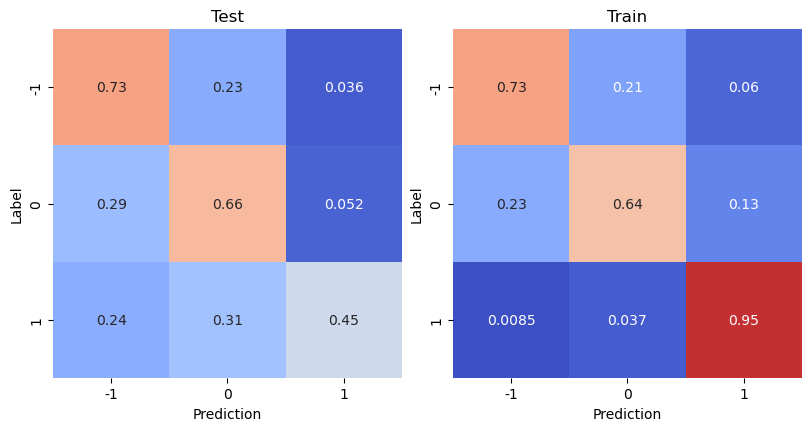

DEG
1    33429
0     3262
2      454
Name: count, dtype: int64
Hipo_Glut
DG_Glut
Processed meta data
Processed enhancer_DMR data
Processed enhancer_peak data
Processed DAR data
Processed DMR data
Processed loops data
Processed mcg_genebody data
Processed mch_genebody data
Processed atac data
CA1-ProS_Glut
Processed meta data
Processed enhancer_DMR data
Processed enhancer_peak data
Processed DAR data
Processed DMR data
Processed loops data
Processed mcg_genebody data
Processed mch_genebody data
Processed atac data
CA3_Glut
Processed meta data
Processed enhancer_DMR data
Processed enhancer_peak data
Processed DAR data
Processed DMR data
Processed loops data
Processed mcg_genebody data
Processed mch_genebody data
Processed atac data
DEG
1    20207
0     3280
2     1649
Name: count, dtype: int64
100%|██████████| 100/100 [03:41<00:00,  2.22s/trial, best loss: -0.6437605361774528]


100%|===================| 60318/60324 [02:48<00:00]        

Train XGB Accuracy: 54.25%
Train Balanced XGB Accuracy: 70.93%
Test XGB Accuracy: 35.62%
Test Balanced XGB Accuracy: 49.54%


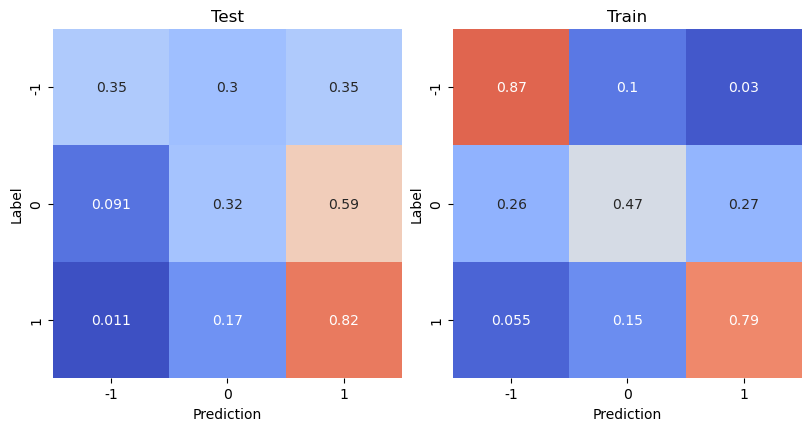

DEG
1    20207
0     3280
2     1649
Name: count, dtype: int64
NN
Astro-TE_NN
Processed meta data
Processed enhancer_DMR data
Processed enhancer_peak data
Processed DAR data
Processed DMR data
Processed loops data
Processed mcg_genebody data
Processed mch_genebody data
Processed atac data
Oligo_NN
Processed meta data
Processed enhancer_DMR data
Processed enhancer_peak data
Processed DAR data
Processed DMR data
Processed loops data
Processed mcg_genebody data
Processed mch_genebody data
Processed atac data
OPC_NN
Processed meta data
Processed enhancer_DMR data
Processed enhancer_peak data
Processed DAR data
Processed DMR data
Processed loops data
Processed mcg_genebody data
Processed mch_genebody data
Processed atac data
DEG
1    16707
0     1128
2      772
Name: count, dtype: int64
100%|██████████| 100/100 [02:44<00:00,  1.64s/trial, best loss: -0.7643558335061142]


100%|===================| 44648/44655 [01:45<00:00]        

Train XGB Accuracy: 77.15%
Train Balanced XGB Accuracy: 86.53%
Test XGB Accuracy: 81.06%
Test Balanced XGB Accuracy: 51.51%


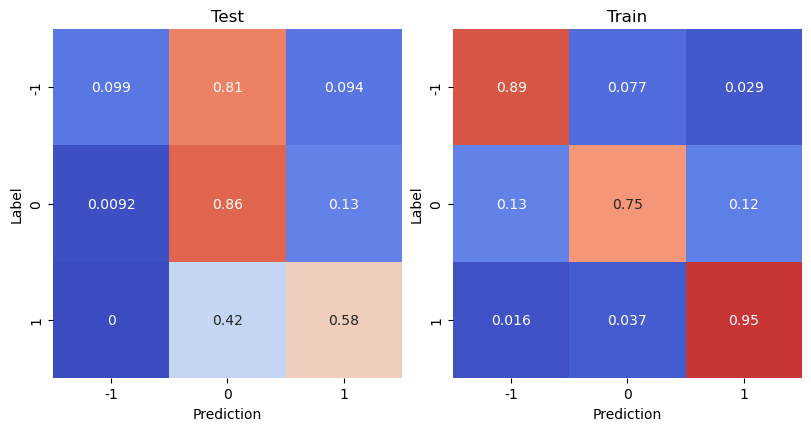

DEG
1    16707
0     1128
2      772
Name: count, dtype: int64


In [23]:
for i, (clust, cell_list) in enumerate(cell_clusters.items()): 
    print(clust)
    X_dict = {}
    y_dict = {}
    for _ct in cell_list: 
        print(_ct)
        DATA_FEATURE_NAMES = DATA_FEATURE_NAMES_DICT[clust]
        X_balanced, y_balanced, FEATURE_TYPES = load_data_wrapper(_ct, DATA_FEATURE_NAMES, 
                                                                  y_val=p_y_val, _testing_type=p_testing_type, rna_type=p_rna_type, 
                                                                 data_filepath = p_data_filepath, na_cutoff=p_na_cutoff)
        y_balanced += 1 # for 0, 1, 2, labels
        X = aggregate_modalities(X_balanced, FEATURE_TYPES)
        X_dict[_ct] = X
        y_dict[_ct] = y_balanced

    X, y_balanced = aggregate_cell_types(X_dict, y_dict, cell_list)
    print(y_balanced.value_counts())
    X_train, X_test, y_train, y_test, kf = split_and_normalize(X, y_balanced, test_size=0.2, random_state=13)

    dtrain_reg = xgb.DMatrix(X_train, y_train)
    dtest_reg = xgb.DMatrix(X_test, y_test)
    # sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)
    # class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
    
    # Training the actual model
    xgb_mod = train_model(X_train, y_train, X_train.columns, objective, space, num_evals=100)
    
    # Getting the shap values
    explainer = shap.TreeExplainer(xgb_mod, X_train) # , feature_perturbation='interventional', model_output="predict_proba")
    shap_values = explainer(X_train, check_additivity=False)
    
    ranked_order = rank_ordering_from_shap(shap_values, X_train)
    ranked_order.to_csv(f"xgb_logging/{clust}.shap_rank_r2.csv")

    # For Plotting Shap Values
    with PdfPages(f"../images/xgb_beeswarm/{clust}_r2.pdf") as pdf:
        ax = shap.plots.beeswarm(shap_values[:, :, 0], max_display=20, show=False)
        ax.set_title("Down Regulated Gene - Feature Importance")
        pdf.savefig(dpi=300, bbox_inches='tight')
        plt.close()
        ax = shap.plots.beeswarm(shap_values[:, :, 1], max_display=20, show=False)
        ax.set_title("Non-Age Regulated Gene - Feature Importance")
        pdf.savefig(dpi=300, bbox_inches='tight')
        plt.close()
        ax = shap.plots.beeswarm(shap_values[:, :, 2], max_display=20, show=False)
        ax.set_title("Up Regulated Gene - Feature Importance")
        pdf.savefig(dpi=300, bbox_inches='tight')
        plt.close()

    # For Plotting and reporting Results
    _ = evaluation_metrics(X_train, X_test, y_train, y_test)
    fig, ax = ccf_metrics(X_train, X_test, y_train, y_test)
    plt.show()
    print(y_train.value_counts() + y_test.value_counts())

# XGBoost (OLD)

### Repeat downsampling feature training

In [203]:
columns_to_keep = X_train.columns
counter = 0
while len(columns_to_keep) > 25 : 
    counter += 1
    
    X_train_sub = X_train[columns_to_keep].copy()
    X_test_sub = X_test[columns_to_keep].copy()
    
    # Performing the hyperparameter search
    trials = Trials()
    best_hyperparams = fmin(fn = objective, space = space, 
                             algo = tpe.suggest, 
                            max_evals = 100, trials = trials)


    # Training a model based on the best hyperparameters 
    xgb_mod = xgb.XGBClassifier(max_depth=int(best_hyperparams['max_depth']), gamma=best_hyperparams['gamma'], 
                               n_estimators = int(best_hyperparams['n_estimators']), reg_alpha = int(best_hyperparams['reg_alpha']), 
                                                 reg_lambda = best_hyperparams['reg_lambda'])
    xgb_mod = xgb_mod.fit(X_train_sub, y_train, sample_weight = sample_weights)

    # Some results on the current iteration of the XGB model
    y_probs = xgb_mod.predict_proba(X_test_sub)
    y_preds = xgb_mod.predict(X_test_sub)
    y_train_preds = xgb_mod.predict(X_train_sub)

    # Getting the importance scores for each feature
    sorted_importance_idx = xgb_mod.feature_importances_.argsort()[::-1]
    # columns_to_keep = []
    for thr in np.arange(0, 1, 0.001): 
        columns_to_keep = xgb_mod.feature_names_in_[np.where(xgb_mod.feature_importances_ > thr)]
        if len(columns_to_keep) / X_train_sub.shape[1] <= 0.8: 
            break
    
    print(len(columns_to_keep))

    # Calculating metrics I want to save per run
    # test_acc = (y_preds == y_test).sum() / len(y_test) * 100
    # train_acc = (y_train_preds == y_train).sum() / len(y_train) * 100
    test_acc = accuracy_score(y_test, y_preds)
    train_acc = accuracy_score(y_train, y_train_preds)
    b_acc = balanced_accuracy_score(y_test, y_preds)

    output_dict = {
        'y_test_labels' : y_test.values.tolist(), 
        'y_test_preds' : y_preds.tolist(), 
        'y_train_labels' : y_train.values.tolist(), 
        'y_train_preds' : y_train_preds.tolist(),
        'cols_to_keep' : columns_to_keep.tolist()
    }
    with open(f"xgb_logging/{_ct}.epoch_{counter}.json", 'w') as fp: 
        json.dump(output_dict, fp)
    
    print("model Train Accuracy: %.2f%%" %(train_acc*100))
    print("model Test Accuracy: %.2f%%" %(test_acc*100))
    print("Balanced XGB Accuracy: %.2f%%" %(b_acc*100))
    

100%|██████████| 100/100 [03:59<00:00,  2.39s/trial, best loss: -0.6137166161738935]
138
model Train Accuracy: 60.84%
model Test Accuracy: 26.50%
Balanced XGB Accuracy: 51.72%
100%|██████████| 100/100 [04:28<00:00,  2.69s/trial, best loss: -0.6142240863264005]
105
model Train Accuracy: 60.91%
model Test Accuracy: 26.81%
Balanced XGB Accuracy: 53.53%
100%|██████████| 100/100 [05:16<00:00,  3.17s/trial, best loss: -0.6167121308194284]
80
model Train Accuracy: 62.89%
model Test Accuracy: 36.13%
Balanced XGB Accuracy: 52.91%
100%|██████████| 100/100 [04:23<00:00,  2.63s/trial, best loss: -0.6147527138215112]
60
model Train Accuracy: 63.15%
model Test Accuracy: 24.36%
Balanced XGB Accuracy: 48.56%
100%|██████████| 100/100 [04:39<00:00,  2.80s/trial, best loss: -0.6137776126849797]
45
model Train Accuracy: 64.09%
model Test Accuracy: 24.66%
Balanced XGB Accuracy: 49.44%
100%|██████████| 100/100 [04:51<00:00,  2.92s/trial, best loss: -0.6158114351920594]
34
model Train Accuracy: 58.74%
model 

In [18]:
trials = Trials()
best_hyperparams = fmin(fn = objective, space = space, 
                         algo = tpe.suggest, 
                        max_evals = 2, trials = trials)

# For default stuff
xgb_mod = xgb.XGBClassifier(max_depth=int(best_hyperparams['max_depth']), gamma=best_hyperparams['gamma'], 
                           n_estimators = int(best_hyperparams['n_estimators']), reg_alpha = int(best_hyperparams['reg_alpha']), 
                                             reg_lambda = best_hyperparams['reg_lambda'])
# xgb_mod = xgb_mod.fit(X_train_sub, y_train, sample_weight = sample_weights)

100%|██████████| 2/2 [00:05<00:00,  2.60s/trial, best loss: -0.6009659677187276]


In [19]:
xgb_mod = xgb_mod.fit(X_train, y_train, sample_weight = sample_weights)

## Testing Shap Select

In [ ]:
from shap_select import shap_select
selected_feature_df = shap_select(xgb_mod, X_test, y_test, task='multiclass', threshold=0.05, alpha=0)

In [23]:
from typing import Any, Tuple, List, Dict

import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats
import shap

In [24]:
def shap_select(
    tree_model: Any,
    validation_df: pd.DataFrame,
    target: pd.Series | str,  # str is column name in validation_df
    feature_names: List[str] | None = None,
    task: str | None = None,
    threshold: float = 0.05,
    return_extended_data: bool = False,
    alpha: float = 1e-6,
) -> pd.DataFrame | Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Select features based on their SHAP values and statistical significance.

    Parameters:
    - tree_model (Any): A trained tree-based model.
    - validation_df (pd.DataFrame): Validation dataset containing the features.
    - feature_names (List[str]): A list of feature names used by the model.
    - target (pd.Series | str): The target values, or the name of the target column in `validation_df`.
    - task (str | None): The task type ('regression', 'binary', or 'multiclass'). If None, it is inferred automatically.
    - threshold (float): Significance threshold to select features. Default is 0.05.
    - return_extended_data (bool): Whether to also return the shapley values dataframe(s) and some extra columns
    - alpha (float): Controls the regularization strength for the regression

    Returns:
    - pd.DataFrame: A DataFrame containing the feature names, statistical significance, and a 'Selected' column
      indicating whether the feature was selected based on the threshold.
    """
    # If target is a string (column name), extract the target series from validation_df
    if isinstance(target, str):
        target = validation_df[target]

    if feature_names is None:
        feature_names = validation_df.columns.tolist()

    # Infer the task if not provided
    if task is None:
        if pd.api.types.is_numeric_dtype(target) and target.nunique() > 10:
            task = "regression"
        elif target.nunique() == 2:
            task = "binary"
        else:
            task = "multiclass"

    if task == "multiclass":
        unique_classes = sorted(list(target.unique()))
        shap_features = create_shap_features(
            tree_model, validation_df[feature_names], unique_classes
        )
    else:
        shap_features = create_shap_features(tree_model, validation_df[feature_names])

    # Compute statistical significance of each feature, recursively ablating
    significance_df = iterative_shap_feature_reduction(
        shap_features, target, task, alpha
    )

    # Add 'Selected' column based on the threshold
    significance_df["selected"] = (
        significance_df["stat.significance"] < threshold
    ).astype(int)
    significance_df.loc[significance_df["t-value"] < 0, "selected"] = -1

    if return_extended_data:
        return significance_df, shap_features
    else:
        return significance_df[
            ["feature name", "t-value", "stat.significance", "coefficient", "selected"]
        ]

In [29]:
tree_model = xgb_mod
validation_df = X_test
target = y_test
feature_names =  None
task='multiclass'
threshold = 0.05
return_extended_data = False,
alpha = 1e-6
if feature_names is None:
    feature_names = validation_df.columns.tolist()
if task == "multiclass":
    unique_classes = sorted(list(target.unique()))
    shap_features = create_shap_features(
        tree_model, validation_df[feature_names], unique_classes
    )

In [34]:
# shap_features

In [25]:
def iterative_shap_feature_reduction(
    shap_features: pd.DataFrame | List[pd.DataFrame],
    target: pd.Series,
    task: str,
    alpha: float = 1e-6,
) -> pd.DataFrame:
    collected_rows = []  # List to store the rows we collect during each iteration

    features_left = True
    while features_left:
        # Call the original shap_features_to_significance function
        significance_df = shap_features_to_significance(
            shap_features, target, task, alpha
        )

        # Find the feature with the lowest t-value
        min_t_value_row = significance_df.loc[significance_df["t-value"].idxmin()]

        # Remember this row (collect it in our list)
        collected_rows.append(min_t_value_row)

        # Drop the feature corresponding to the lowest t-value from shap_features
        feature_to_remove = min_t_value_row["feature name"]
        if isinstance(shap_features, pd.DataFrame):
            shap_features = shap_features.drop(columns=[feature_to_remove])
            features_left = len(shap_features.columns)
        else:
            shap_features = {
                k: v.drop(columns=[feature_to_remove]) for k, v in shap_features.items()
            }
            features_left = len(list(shap_features.values())[0].columns)

    # Convert collected rows back to a dataframe
    result_df = (
        pd.DataFrame(collected_rows)
        .sort_values(by="t-value", ascending=False)
        .reset_index()
    )

    return result_df

In [38]:
significance_df

,feature name,t-value,closeness to 1.0,coefficient,stat.significance
0,18mo.2mo.Q.max.loops,NaN,0.639999,1.639999,NaN
1,18mo.2mo.Q.mean.loops,NaN,1.000000,0.000000,NaN
2,18mo.2mo.Q.median.loops,NaN,0.902783,0.097217,NaN
3,18mo.2mo.Q.min.loops,NaN,0.564005,2.422084,NaN
4,18mo.2mo.Q.skew.loops,NaN,0.913949,0.086051,NaN
...,...,...,...,...,...
110,count.atac,NaN,0.726413,2.294136,NaN
111,count.loops,NaN,1.000000,0.000000,NaN
112,gene_length.meta,NaN,1.602363,6.931101,NaN
113,log2_distance.mean.atac,NaN,0.972021,0.027979,NaN


In [75]:
# Add a constant to the features for the intercept in logistic regression
feature_df += 0.001
shap_features_with_constant = sm.add_constant(feature_df)

In [76]:
logit_model = sm.Logit(binary_target, shap_features_with_constant)

In [93]:
result = logit_model.fit_regularized(disp=False, alpha=alpha, maxiter=1000)

/gale/netapp/home2/aklein/miniconda3/envs/agp/lib/python3.10/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 114 out of 115 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/gale/netapp/home2/aklein/miniconda3/envs/agp/lib/python3.10/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/gale/netapp/home2/aklein/miniconda3/envs/agp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [91]:
result = logit_model.fit(disp=False, method='nm', maxiter=1000)

/gale/netapp/home2/aklein/miniconda3/envs/agp/lib/python3.10/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/gale/netapp/home2/aklein/miniconda3/envs/agp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [94]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                                        Results: Logit
==============================================================================================================================================================================================
Model:                                                         Logit                                                     Method:                                                    MLE       
Dependent Variable:                                            DEG                                                       Pseudo R-squared:                                          0.348     
Date:                                                          2024-12-09 18:02                                          AIC:                                                       705.6361  
No. Observations:                                              1630                                                      BIC:                                                       1326.2146 
Df Model:                                                      114                                                       Log-Likelihood:                                            -237.82   
Df Residuals:                                                  1515                                                      LL-Null:                                                   -364.99   
Converged:                                                     0.0000                                                    LLR p-value:                                               1.0288e-12
No. Iterations:                                                1000.0000                                                 Scale:                                                     1.0000    
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                            Coef.               Std.Err.                    z        P>|z|                [0.025                           0.975]             
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
gene_length.meta                                             6.5178                              nan             nan    nan                               nan                              nan
9mo.2mo.activity.log_ratio.count.20kb-1Mb.enhancer_DMR     -29.5132                           7.9114         -3.7305 0.0002                          -45.0193                         -14.0071
18mo.2mo.activity.log_ratio.count.20kb-1Mb.enhancer_DMR    -36.2682                              nan             nan    nan                               nan                              nan
18mo.9mo.activity.log_ratio.count.20kb-1Mb.enhancer_DMR    -36.2682                              nan             nan    nan                               nan                              nan
9mo.2mo.contact.log_ratio.count.20kb-1Mb.enhancer_DMR      -36.2682        14229513446516393984.0000         -0.0000 1.0000        -27889333872700547072.0000        27889333872700547072.0000
18mo.2mo.contact.log_ratio.count.20kb-1Mb.enhancer_DMR     -36.2682         8024705058341104640.0000         -0.0000 1.0000        -15728132900904957952.0000        15728132900904957952.0000
18mo.9mo.contact.log_ratio.count.20kb-1Mb.enhancer_DMR     -36.2682                              nan             nan    nan                               nan                              nan
9mo.2mo.activity.log_ratio.mean.20kb-1Mb.enhancer_peak     -36.2682        16294571715590856704.0000         -0.0000 1.0000        -31936773706063118336.0000        31936773706063118336.0000
9mo.2mo.activity.log_ratio.m

In [ ]:
# Add a constant to the features for the intercept in logistic regression
shap_features_with_constant = sm.add_constant(feature_df)

# Fit the logistic regression model that will generate confidence intervals
logit_model = sm.Logit(target, shap_features_with_constant)
# result = logit_model.fit_regularized(disp=False, alpha=alpha)
result = logit_model.fit(disp=False, alpha=alpha, method='bfgs')

# Extract the results
summary_frame = result.summary2().tables[1]

# Create the DataFrame with the required columns
result_df = pd.DataFrame(
    {
        "feature name": summary_frame.index,
        "coefficient": summary_frame["Coef."],
        "stderr": summary_frame["Std.Err."],
        "stat.significance": summary_frame["P>|z|"],
        "t-value": summary_frame["Coef."] / summary_frame["Std.Err."],
    }
).reset_index(drop=True)
result_df["closeness to 1.0"] = (result_df["coefficient"] - 1.0).abs()
return result_df.loc[~(result_df["feature name"] == "const"), :]

In [41]:
significance_dfs = []

# Iterate through each class and perform binary classification (one-vs-all)
for cls, feature_df in shap_features.items():
    binary_target = (target == cls).astype(int)
    break
    significance_df = binary_classifier_significance(
        feature_df, binary_target, alpha
    )
    significance_dfs.append(significance_df)

# Combine results into a single DataFrame with the max significance value for each feature
# combined_df = pd.concat(significance_dfs)
# max_significance_df = (
#     combined_df.groupby("feature name", as_index=False)
#     .agg(
#         {
#             "t-value": "max",
#             "closeness to 1.0": "min",
#             "coefficient": "max",
#         }
#     )
#     .reset_index(drop=True)
# )

# # Len(shap_features) multiplier is the Bonferroni correction
# max_significance_df["stat.significance"] = max_significance_df["t-value"].apply(
#     lambda x: len(shap_features) * (1 - stats.norm.cdf(x))
# )
# if return_individual_significances:
#     return max_significance_df, significance_dfs
# else:
#     return max_significance_df

In [37]:
features_left = True
while features_left:
    # Call the original shap_features_to_significance function
    significance_df = shap_features_to_significance(
        shap_features, target, task, alpha
    )

    # Find the feature with the lowest t-value
    min_t_value_row = significance_df.loc[significance_df["t-value"].idxmin()]

    # Remember this row (collect it in our list)
    collected_rows.append(min_t_value_row)

    # Drop the feature corresponding to the lowest t-value from shap_features
    feature_to_remove = min_t_value_row["feature name"]
    if isinstance(shap_features, pd.DataFrame):
        shap_features = shap_features.drop(columns=[feature_to_remove])
        features_left = len(shap_features.columns)
    else:
        shap_features = {
            k: v.drop(columns=[feature_to_remove]) for k, v in shap_features.items()
        }
        features_left = len(list(shap_features.values())[0].columns)

# Convert collected rows back to a dataframe
# result_df = (
#     pd.DataFrame(collected_rows)
#     .sort_values(by="t-value", ascending=False)
#     .reset_index()
# )

/gale/netapp/home2/aklein/miniconda3/envs/agp/lib/python3.10/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method bfgs is: gtol, norm, epsilon. The list of unsupported keyword arguments passed include: alpha. After release 0.14, this will raise.
  warnings.warn(
/gale/netapp/home2/aklein/miniconda3/envs/agp/lib/python3.10/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/gale/netapp/home2/aklein/miniconda3/envs/agp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/gale/netapp/home2/aklein/miniconda3/envs/agp/lib/python3.10/site-packages/statsmodels/base/op

In [26]:
def create_shap_features(
    tree_model: Any, validation_df: pd.DataFrame, classes: List | None = None
) -> pd.DataFrame | Dict[Any, pd.DataFrame]:
    """
    Generates SHAP (SHapley Additive exPlanations) values for a given tree-based model on a validation dataset.

    Parameters:
    - tree_model (Any): A trained tree-based model (e.g., XGBoost, LightGBM, or any model compatible with SHAP).
    - validation_df (pd.DataFrame): A DataFrame containing the validation data on which SHAP values will be computed.
      The DataFrame should contain the same feature columns used to train the `tree_model`.

    Returns:
    - pd.DataFrame: A DataFrame containing the SHAP values for each feature in the `validation_df`, where each column
      corresponds to the SHAP values of a feature, and the rows match the index of the `validation_df`.
    """
    explainer = shap.Explainer(tree_model, model_output="raw")(validation_df)
    shap_values = explainer.values

    if len(shap_values.shape) == 2:
        assert (
            classes is None
        ), "Don't specify classes for binary classification or regression"
        # Create a DataFrame with the SHAP values, with one column per feature
        return pd.DataFrame(
            shap_values, columns=validation_df.columns, index=validation_df.index
        )
    elif len(shap_values.shape) == 3:  # multiclass classification
        out = {}
        for i, c in enumerate(classes):
            out[i] = pd.DataFrame(
                shap_values[:, :, i],
                columns=validation_df.columns,
                index=validation_df.index,
            )
        return out

In [35]:
def shap_features_to_significance(
    shap_features: pd.DataFrame | List[pd.DataFrame],
    target: pd.Series,
    task: str,
    alpha: float,
) -> pd.DataFrame:
    """
    Determines the task (regression, binary, or multi-class classification) based on the target and calls the appropriate
    significance function. Returns a DataFrame with feature names and their significance values.

    Parameters:
    shap_features (pd.DataFrame): A DataFrame containing the features used for prediction.
    target (pd.Series): The target series for prediction (either continuous or categorical).
    task (str): The type of task to perform: "regression", "binary", or "multiclass".

    Returns:
    pd.DataFrame: A DataFrame containing:
        - feature name: The names of the features.
        - stat.significance: The p-value (statistical significance) for each feature.
        Sorted in descending order of significance (ascending p-value).
    """

    # Call the appropriate function based on the task
    if task == "regression":
        result_df = regression_significance(shap_features, target, alpha)
    elif task == "binary":
        result_df = binary_classifier_significance(shap_features, target, alpha)
    elif task == "multiclass":
        result_df = multi_classifier_significance(shap_features, target, alpha)
    else:
        raise ValueError("`task` must be 'regression', 'binary', 'multiclass' or None.")

    # Sort the result by statistical significance in ascending order (more significant features first)
    result_df_sorted = result_df.sort_values(by="t-value", ascending=False).reset_index(
        drop=True
    )

    return result_df_sorted

In [97]:
def binary_classifier_significance(
    shap_features: pd.DataFrame, target: pd.Series, alpha: float
) -> pd.DataFrame:
    """
    Fits a logistic regression model using the features from `shap_features` to predict the binary `target`.
    Returns a DataFrame containing feature names, coefficients, standard errors, and the significance (p-values).

    Parameters:
    shap_features (pd.DataFrame): A DataFrame containing the SHAP values or features used for prediction.
    target (pd.Series): A binary target series (0 or 1) to classify.

    Returns:
    pd.DataFrame: A DataFrame containing:
        - feature name: The names of the features.
        - coefficient: The logistic regression coefficients for each feature.
        - stderr: The standard error for each coefficient.
        - stat.significance: The p-value (statistical significance) for each feature.
    """

    # Add a constant to the features for the intercept in logistic regression
    shap_features += 0.0001
    shap_features_with_constant = sm.add_constant(shap_features)

    # Fit the logistic regression model that will generate confidence intervals
    logit_model = sm.Logit(target, shap_features_with_constant)
    result = logit_model.fit_regularized(disp=False, alpha=alpha, maxiter=1000)
    # result = logit_model.fit(disp=False, alpha=alpha, method='bfgs')

    # Extract the results
    summary_frame = result.summary2().tables[1]

    # Create the DataFrame with the required columns
    result_df = pd.DataFrame(
        {
            "feature name": summary_frame.index,
            "coefficient": summary_frame["Coef."],
            "stderr": summary_frame["Std.Err."],
            "stat.significance": summary_frame["P>|z|"],
            "t-value": summary_frame["Coef."] / summary_frame["Std.Err."],
        }
    ).reset_index(drop=True)
    result_df["closeness to 1.0"] = (result_df["coefficient"] - 1.0).abs()
    return result_df.loc[~(result_df["feature name"] == "const"), :]

In [28]:
def multi_classifier_significance(
    shap_features: Dict[Any, pd.DataFrame],
    target: pd.Series,
    alpha: float,
    return_individual_significances: bool = False,
) -> (pd.DataFrame, list):
    """
    Fits a binary logistic regression model for each unique class in the target, comparing each class against all others (one-vs-all).
    Calls binary_classifier_significance for each binary classification.

    Parameters:
    shap_features (pd.DataFrame): A DataFrame containing the features used for classification.
    target (pd.Series): A target series containing more than two classes.

    Returns:
    - A DataFrame with feature names and their maximum significance values across all binary classifications.
    - A list of DataFrames, one for each binary classification, containing feature names, coefficients, standard errors, and statistical significance.
    """
    significance_dfs = []

    # Iterate through each class and perform binary classification (one-vs-all)
    for cls, feature_df in shap_features.items():
        binary_target = (target == cls).astype(int)
        significance_df = binary_classifier_significance(
            feature_df, binary_target, alpha
        )
        significance_dfs.append(significance_df)

    # Combine results into a single DataFrame with the max significance value for each feature
    combined_df = pd.concat(significance_dfs)
    max_significance_df = (
        combined_df.groupby("feature name", as_index=False)
        .agg(
            {
                "t-value": "max",
                "closeness to 1.0": "min",
                "coefficient": "max",
            }
        )
        .reset_index(drop=True)
    )

    # Len(shap_features) multiplier is the Bonferroni correction
    max_significance_df["stat.significance"] = max_significance_df["t-value"].apply(
        lambda x: len(shap_features) * (1 - stats.norm.cdf(x))
    )
    if return_individual_significances:
        return max_significance_df, significance_dfs
    else:
        return max_significance_df